# Imports

In [1]:
# og python libs
from typing import List, Dict, Any, Tuple, Pattern
import time
import re
import os
import pprint

# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
from scipy.constants import k as k_B, c, N_A

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

# GenAI
from google import genai
from google.genai import types

# natural data databases
import hapi
DB_PATH = 'hapi_data'
hapi.db_begin(DB_PATH)

# API setups
G_MODEL_ID = "gemini-2.5-flash-preview-05-20"
G_API_KEY = os.environ.get("GEMINI_API_KEY")
G_CLIENT = genai.Client(api_key=G_API_KEY)

response = G_CLIENT.models.generate_content(
    model=G_MODEL_ID,
    contents="test",
)

print(response.text)

pp = pprint.PrettyPrinter(depth=4)

HAPI version: 1.2.2.3
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

# Useful custom defs

## defs

In [2]:
def dir_match_dict(path: str, patterns: Dict[int, Dict[int, Pattern[str]]]) -> Dict[int, Dict[int, List[str]]]:
    """
    Gets out structured dictionary of dictionaries from `create_regex_strings()` return value.

    Args:
        patterns (Dict[int, Dict[int, List[Pattern[str]]]]): Output of `create_regex_strings`
    
    Returns:
        (Dict[int, Dict[int, List[str]]]): Lists of filenames in a structured manner
        
    ```
    {pressure:
        {frequency:
            [filename1, filename2, ...],
            .
            .
            .
        frequency_n:
            [...]},
    .
    .
    .
    pressure_n: ...}
    ```
    """
    filenames = {}
    for k1, v1 in patterns.items():
        filenames[k1] = {}
        for k2, v2 in v1.items():
            filenames[k1][k2] = [f for f in dir_match(path, v2)]

    return filenames

def create_regex_strings(list1: List[int], list2: List[int]) -> Dict[int, Dict[int, Pattern[str]]]:
    """
    Runs a nested for loop to mach each `list1` item with each
    `list2` item in an appropriate raw string to use with regex

    Args:
        list1 (List[int]): List, e.g. of pressures
        list2 (List[int]): List, e.g. of frequencies
    
    Returns:
        List[str]: The generated list of strings, to use wherever
    """
    patterns: Dict[int, Dict[int, Pattern[str]]] = {}
    for l1 in list1:
        patterns[l1] = {}
        for l2 in list2:
            current_string = re.compile(f"gasx_{l1}_(12|24|32)_{l2}__msr__[0-9]{{1,2}}")
            patterns[l1][l2] = current_string 
    return patterns

def gaussian_hwhm(v0, T, M):
    """Calculates the Gaussian (Doppler) HWHM in cm^-1."""
    # mass_of_molecule is the mass of a single molecule in kg
    mass_of_molecule = M / N_A
    return v0 * np.sqrt(2 * k_B * T * np.log(2) / (mass_of_molecule * c**2))

def lorentzian_hwhm(P_atm, T, gamma_L0, T0, n):
    """Calculates the Lorentzian (Pressure) HWHM in cm^-1."""
    # Pressure broadening coeff scaled by temperature
    gamma_L = gamma_L0 * (T0 / T)**n
    return P_atm * gamma_L

def get_n_strongest(molecule_name: str, molar_mass: float, start: float, end: float, n: int) -> List[Dict[str, Any]]:
    """
    Gets `n` most intensive line parameters for molecule of `molecule_name` from HITRAN database in range
    from `start` to `end`, using `hapi` library

    Args:
        molecule_name (str): name of the molecule, e.g., `'h2o'`
        molar_mass (float): molar mass of the molecule in kg/mol
        start (float): start of the range to work on (in wavenumbers)
        end (float): end of the range to work on (in wavenumbers)
        n (int): amount of lines to return, starting with the most intensive lines
    
    Returns:
        List[Dict[str, Any]]: Returns a list of parameter dicts, w/ names as per `hapi` nomenclature
    """
    line_dicts = []
    
    MOLECULE_NAME = str.upper(molecule_name)
    hapi.fetch(MOLECULE_NAME, 1, 1, start, end)

    line_strengths = hapi.getColumn(MOLECULE_NAME, 'sw') # sw is the line intensity
    line_strengths_df = pd.DataFrame({
        "og_order": list(range(len(line_strengths))),
        "sw": line_strengths
    })
    strongest_line_indexes = line_strengths_df.sort_values(by="sw", ascending=False)[:n]['og_order']

    for strongest_line_index in strongest_line_indexes:
    
        MOL_LINE_PARAMS = {
            'v0': hapi.getColumn(MOLECULE_NAME, 'nu')[strongest_line_index], # Line center in cm^-1
            'gamma_L0': hapi.getColumn(MOLECULE_NAME, 'gamma_air')[strongest_line_index], # Air-broadening coeff at T0, P0
            'n_exp': hapi.getColumn(MOLECULE_NAME, 'n_air')[strongest_line_index], # Temperature exponent
            'T0': 296.0, # Reference Temperature
            'P0': 1.0, # Reference Pressure (atm)
            'M': molar_mass # Molar mass of H2O in kg/mol
        }
        print(f"--- Fetched {molecule_name.upper()} Line Parameters from HITRAN ---")
        for key, val in MOL_LINE_PARAMS.items():
            print(f"{key}: {val}")

        line_dicts.append(MOL_LINE_PARAMS)

    return line_dicts

def dir_match(path: str, pattern: Pattern[str]) -> list[str]:
    """
    Iterates through contents of dir and matches according to some regex pattern

    Args:
        path (str): path to directory of interest
        pattern (str): pattern to find, either simple or regex
    
    Returns:
        list[str]: All matches
    """
    matched = []
    dir_contents = sorted(os.listdir(path))
    for item in dir_contents:
        if re.match(pattern, item) is not None:
            matched.append(item)
    return matched

def subtract_hex(n1: str, n2: str) -> str:
    """
    Does subtraction in hex

    Args:
        n1 (str): First number as a string
        n2 (str): Second number as a string
    
    Returns:
        str: a hex subtraction
    """
    h1 = int(n1, 16)
    h2 = int(n2,16)
    return hex(abs(h1-h2))

def sum_hex(n1: str, n2: str) -> str:
    """
    Sums two numbers in hex

    Args:
        n1 (str): First number as a string
        n2 (str): Second number as a string
    
    Returns:
        str: a hex subtraction
    """
    h1 = int(n1, 16)
    h2 = int(n2, 16)
    return hex(h1+h2)

def get_wavenumber(unit1: float, units1: List[float], units2: List[float]) -> List[float]:
    """
    Converts `unit1` to `unit2` based on the
    `sklearn.linear_model.LinearRegression()`
    fit of lists `units1` and `units2`

    Args:
        unit1 (float): Value of interest (unit from which will convert)
        units1 (list[float]): List of values in units of interest
        units2 (list[float]): List of values in units from which we are converting
    
    Returns:
        List[float]: Value in units of interest, slope, intercept
    """
    lr_wavenumbers = LinearRegression()
    offset_arr = np.array(units1).reshape(-1, 1)
    wavnumber_arr = np.array(units2).reshape(-1, 1)
    lr_wavenumbers.fit(offset_arr, wavnumber_arr)
    a = float(lr_wavenumbers.coef_[0][0])
    b = float(lr_wavenumbers.intercept_[0]) # type: ignore
    return [a*unit1 + b, a, b]

def get_modamp_around_line_in_wav(modamps: List[str], line_in_offsets: float, conversion_params: Tuple[float, float]) -> List[float]:
    """
    Effectively converts modulation amplitude
    from LabView hexes to [somewhat] actual wavenumbers cm-1

    Args:
        modamps (List[str]): Gives a list of modamps as hex strings (w/0 '0x' prepended)
        line_in_offsets (float): Line position in offsets (decimal)
    
    Returns:
        List[float]: Modulation amplitudes in wavenumbers cm-1

    """
    amp_wav_list = []
    for amp in modamps:
        offset = int(f"0x{amp}", 16)
        left_bound = line_in_offsets - offset/2
        right_bound = line_in_offsets + offset/2
        left_bound = conversion_params[0]*left_bound + conversion_params[1] # type: ignore
        right_bound = conversion_params[0]*right_bound + conversion_params[1] # type: ignore
        mod_amp = left_bound - right_bound
        amp_wav_list.append(mod_amp)
    return amp_wav_list

def amp_test_plot(pressure_string: str | int, path: str, amp_test_dict: Dict, used_amps: List[str]|List[int], vlinepos: float, ow_params: Tuple[List[float], List[float]]) -> None:
    """
    Do some parameter tests on specific line,
    For example, plot a line with different laser
    power/current modulation amplitudes or modulation frequencies

    Args:
        pressure_string (str | int): used to retrieve data according to pressure in filename
        path (str): used for underlying `CEPAS_measurement()` call
        ampt_test_dict (Dict): Just an empty dict, in which all used measurements are supposed to be stored (created globally before call)
        ow_params (Tuple[List[float], List[float]]): pass two lists in the tuple that will be used for a fit to add wavnumbers axis 
        vlinepos (float): argument which can be useful with `ipywidgets.interact`-ish calls to find some positions
    
    Returns:
        None: Just plots multiple plots on top of each other, with legend of different parameters used
    """
    maxs = [] # to draw
    mins = [] # a vertical red line
    plt.clf()
    plt.figure(figsize=(10, 10))
    for i in used_amps:
        # auto_freq_test[f'cm{i}_fl'] = CEPAS_measurement(path=path2, path_signature=f"gasx_600_51_{i}__msr__", cols=col_names)
        amp_test_dict[f'cm{i}_fl'] = CEPAS_measurement(path=path, path_signature=f"gasx_{pressure_string}_{i}_20__msr__", cols=col_names) # type: ignore
        amp_test_dict[f'cm{i}_fl'].spectra_list[0]['wav'] = get_wavenumber(amp_test_dict[f'cm{i}_fl'].spectra_list[0]['offset1'], ow_params[0], ow_params[1])[0] # type: ignore
        # auto_test[f'cm{i}_fl'].water_plot()
        # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[0]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[0]['RH'], label=f"{i}")
        # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[1]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[1]['RH'], label=f"{i}")
        # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[2]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[2]['RH'], label=f"{i}")
        min_val = abs(amp_test_dict[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].min())
        max_val = abs(amp_test_dict[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].max())
        mins.append(min_val)
        maxs.append(max_val)
        ratio = max_val / min_val
        plt.plot(amp_test_dict[f'cm{i}_fl'].spectra_list[0]['wav'], amp_test_dict[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'], label=f'Amplitude = {i}, PTR={ratio:.2f}')
    plt.legend(loc=2)
    plt.vlines(vlinepos, ymin=-np.max(np.array(mins)), ymax=np.max(np.array(maxs)), colors=['red'])
    plt.title(f"{pressure_string} mbar")
    plt.show()

def extract_PT_ratios(tests: dict) -> dict:
    """
    In the data of a single line, returns the ratio abs(max)/abs(min)

    Args:
        tests (dict): takes dict of the `CEPAS_measurement` objects

    Returns:
        dict: dictionary of each individual spectra PT ratio

    """
    for_barplot = {}
    for test in list(tests.keys()):
        print(test)
        for_barplot[test] = {}
        for subtest in tests[test]:
            min_val = abs(tests[test][subtest].spectra_list[0]['H2_pnorm'].min())
            max_val = abs(tests[test][subtest].spectra_list[0]['H2_pnorm'].max())
            ratio = max_val / min_val
            key = f"Amplitude: {subtest}"
            value = ratio
            for_barplot[test][key] = value
    
    return for_barplot

def askai(prompt: str) -> str | None:
    """
    Simple wrapper to ask questions to gemini with just a string
    as argument
    """
    model = G_MODEL_ID
    client = G_CLIENT

    response = client.models.generate_content(
        model=model,
        contents=prompt,
    )

    return response.text

def defai(prompt:str, defname: str) -> str | None:
    """
    Returns a string that you can directly pass to `exec()`,
    provided you have defined `G_MODEL_ID`, `G_CLIENT` and have an
    api key from Google gemini
    """
    model = G_MODEL_ID
    client = G_CLIENT
    response = client.models.generate_content(
        model=model,
        contents=f"Provide docstringed and type-hinted python function named '{defname}' for the following prompt (in the output include only the code text!!!):\n" + prompt
    )
    to_exec = response.text
    if to_exec.startswith("```python") and to_exec.endswith("```"): # type: ignore
        to_exec = to_exec[len("```python"):-len("```")].strip() # type: ignore
        print("Stripped!")
    return to_exec # type: ignore

def get_voigt(v0: float, sigma_g: float, gamma_l: float, wavenumber_axis: np.ndarray|float=np.linspace(6983.4, 6984, 1000)) -> np.ndarray:
    relative_wavenumber = wavenumber_axis - v0
    return voigt_profile(relative_wavenumber, sigma_g, gamma_l)

def get_range(df: pd.DataFrame, axis: str, ax0: float, ax1: float) -> pd.DataFrame:
    ddf = df[df[axis] > ax0 and df[axis] < ax1]
    return ddf

def voigt_fit(f, xdata, ydata) -> Tuple[np.ndarray, np.ndarray]:
    popt, pcov = curve_fit(f, xdata, ydata)
    return popt, pcov

def get_fwhm_theory(xdata: np.ndarray, ydata: np.ndarray) -> float:
    """
    Returns a value of full width at half maximum of spectral line-like data
    
    Args:
        xdata (float): x data
        ydata (float): y data
    
    Returns:
        List: [voigt fit, fwhm]

    """
    min_diff_x0 = 1
    min_diff_x1 = 1
    found_x0 = 0
    found_x1 = 0
    for idx in range(len(ydata)):
        diff = ydata.max()/2 - ydata[idx]
        if idx <= np.where(ydata == ydata.max())[0][0]:
            if abs(diff) < min_diff_x0:
                min_diff_x0 = abs(diff)
                found_x0 = xdata[idx]
            else:
                continue
        else:
            if abs(diff) < min_diff_x1:
                min_diff_x1 = abs(diff)
                found_x1 = xdata[idx]
    return found_x1-found_x0
    

## tests

In [3]:
T = 292.15
P_atm = 0.9
wavenumber_axis = np.linspace(6983.4, 6984, 1000)
params = get_n_strongest('h2o', 18.015e-3, 6983.4, 6983.8, 1)[0]
hwhm_g = gaussian_hwhm(params['v0'], T, params['M'])
sigma_g = hwhm_g / np.sqrt(2 * np.log(2))
gamma_l = lorentzian_hwhm(P_atm, T, params['gamma_L0'], params['T0'], params['n_exp'])
data = get_voigt(params['v0'], sigma_g, gamma_l, wavenumber_axis)
print(type(np.where(data == data.max())))


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to hapi_data/H2O.data
Header written to hapi_data/H2O.header
END DOWNLOAD
                     Lines parsed: 9
PROCESSED
--- Fetched H2O Line Parameters from HITRAN ---
v0: 6983.667843
gamma_L0: 0.0905
n_exp: 0.73
T0: 296.0
P0: 1.0
M: 0.018015
<class 'tuple'>


3.83027428613938
(array([255.12230805]), array([2.08226874]), array([318.39745738]), array([573.51976543]))
0.16696696696726576


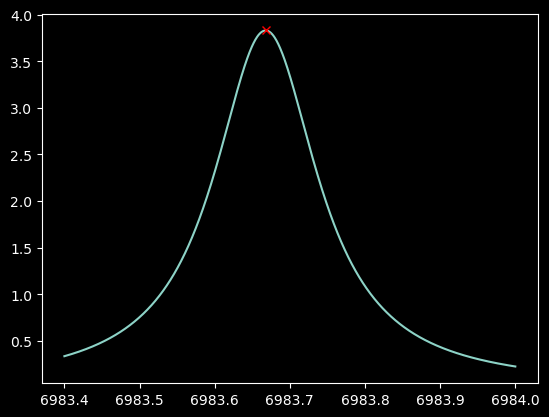

In [4]:
peaks, _ = find_peaks(data)
width = peak_widths(data, peaks, 0.5)
print(data.max())
print(width)
print(get_fwhm_theory(wavenumber_axis, data))
plt.plot(wavenumber_axis, data)
plt.plot(wavenumber_axis[peaks], data[peaks], 'rx')
plt.show()

In [5]:
prompt = "a function that returns the result of 13^2"
test = defai(prompt, "onesixnine")
test

Stripped!


'def onesixnine() -> int:\n    """\n    Calculates and returns the square of 13.\n\n    This function specifically computes 13 * 13, which results in 169.\n\n    Returns:\n        int: The result of 13 squared, which is 169.\n    """\n    return 13 ** 2'

In [6]:
exec(test) # type: ignore
onesixnine() # type: ignore  # noqa: F821


169

In [7]:
askai("Hello how are you?")

"Hello!\n\nAs an AI, I don't have feelings or a physical state, but I'm functioning perfectly and ready to assist you.\n\nHow are *you* doing today, and how can I help you?"

In [8]:
path = './datas/full_tests/'
path2 = './datas/freq_tests/1/'
freq_list = [20, 32, 42, 74, 98, 130, 171, 227, 300]
for i in freq_list:
    test_pattern = re.compile(f".+600_51_{i}.+")
    print(dir_match(path2, test_pattern))

['gasx_600_51_20__msr__0', 'gasx_600_51_20__msr__1', 'gasx_600_51_20__msr__2']
['gasx_600_51_32__msr__3', 'gasx_600_51_32__msr__4', 'gasx_600_51_32__msr__5']
['gasx_600_51_42__msr__6', 'gasx_600_51_42__msr__7', 'gasx_600_51_42__msr__8']
['gasx_600_51_74__msr__10', 'gasx_600_51_74__msr__11', 'gasx_600_51_74__msr__9']
['gasx_600_51_98__msr__12', 'gasx_600_51_98__msr__13', 'gasx_600_51_98__msr__14']
['gasx_600_51_130__msr__15', 'gasx_600_51_130__msr__16', 'gasx_600_51_130__msr__17']
['gasx_600_51_171__msr__18', 'gasx_600_51_171__msr__19', 'gasx_600_51_171__msr__20']
['gasx_600_51_227__msr__21', 'gasx_600_51_227__msr__22', 'gasx_600_51_227__msr__23']
['gasx_600_51_300__msr__24', 'gasx_600_51_300__msr__25', 'gasx_600_51_300__msr__26']


# For analysis

## 16.05.2025 Single point test data analysis

/tmp/ipykernel_1997/2168176887.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  single_point_test = pd.read_csv("./datas/point_tests/point0", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)


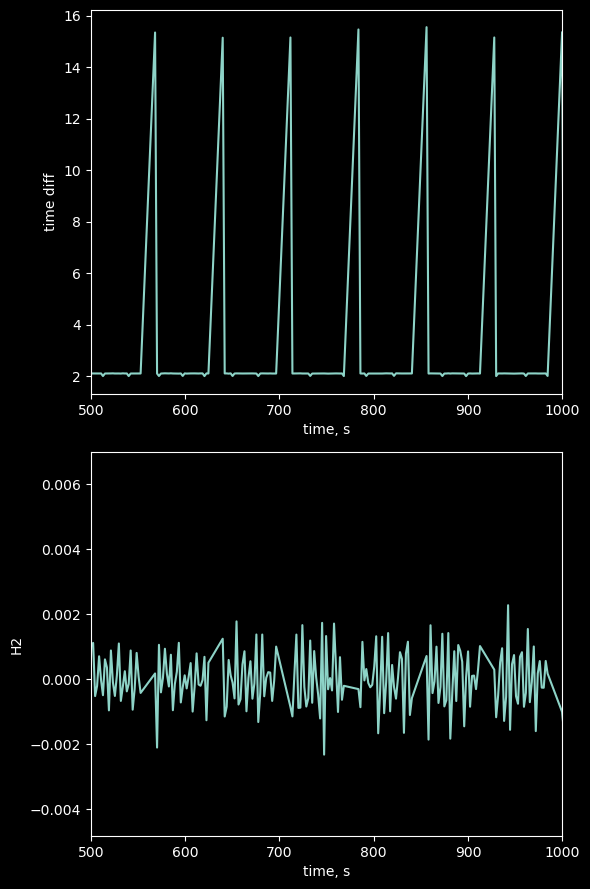

In [9]:
col_names = {
    0: 'time',          # time (measurement tick, stopped on gasx, arbitrary)
    1: 'offset1',       # DFB offset-1
    2: 'P1',            # onboard pressure sensor (blue tube)
    3: 'H3',            # 3rd harmonic (L1H1)
    4: 'H2',            # 2nd harmonic (L1H2)
    5: 'P_las',         # laser power (some volts)
    6: 'T_las',         # diode temp (Kelvin)
    7: 'RH',            # humidity sensor (external)
    8: 'Pressure'       # sensor (external)
}

single_point_test = pd.read_csv("./datas/point_tests/point0", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)
single_point_test_gasx = pd.read_csv("./datas/point_tests/point_gasx_2", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)



df_single_diff = single_point_test_gasx.iloc[1:,:].copy().diff(axis=0, periods=1)
df_single = single_point_test_gasx.iloc[1:,:].copy()

# df_single['time'] -= df_single['time'].min()
plt.figure(figsize=(6, 9))
plt.subplot(211)
plt.plot(df_single['time'], df_single_diff['time'])
# plt.hlines(y=[df_single_diff['H2'].mean(), df_single_diff['H2'].mean() - df_single_diff['H2'].std(), df_single_diff['H2'].mean() + df_single_diff['H2'].std()], xmin=0, xmax=4000, colors=['black', 'red', 'red'])
plt.xlim(500, 1000)
plt.xlabel("time, s")
plt.ylabel("time diff")

plt.subplot(212)
plt.plot(df_single['time'], df_single_diff['H2'])
# plt.hlines(y=[df_single_diff['H2'].mean(), df_single_diff['H2'].mean() - df_single_diff['H2'].std(), df_single_diff['H2'].mean() + df_single_diff['H2'].std()], xmin=0, xmax=4000, colors=['black', 'red', 'red'])
plt.xlim(500, 1000)
plt.xlabel("time, s")
plt.ylabel("H2")

plt.tight_layout()
plt.show()

## Measurement visualization class

In [10]:
class CEPAS_measurement():

    def __init__(self, path: str, path_signature: str | Pattern[str], cols: Dict[int, str]) -> None:
        """
        Initialize measurement from csv file to do data anlysis in python (pandas, numpy etc.)
        Collects all measurement files according to specified `path` and `path_signature`.
        collects all specified spectra in attribute `spectra_list`
        Adds `time_subtracted` column and `_pnorm` power normalized columns.
        Add 2 peaks of interest to see them up close in subplots.
        Can change peaks later with `redo_peaks()`

        Args:
            path (str): pass a path where spectra measurement files are located
            path_signature (str | Pattern[str]): pass a string or pattern to use as regex to find files
            cols (Dict[int, str]): pass a dict of columns to use as new column names
        
        Returns:
            None: but creates attributes
        """    
        self.path = path
        self.raw_spectra = [pd.read_csv(path+self.dir_match(path_signature)[i], sep=r'\s+', header=None, names=list(cols.values()), index_col=False) for i in range(len(self.dir_match(path_signature)))]
        self.n_spectra = len(self.raw_spectra)

        self.spectra_list = [self.raw_spectra[i].iloc[1:,:].copy() for i, _ in enumerate(self.raw_spectra)]
        for df_idx in range(len(self.spectra_list)):
            self.spectra_list[df_idx].loc[:,'time_subtracted'] = self.spectra_list[df_idx]['time']           
            self.spectra_list[df_idx].loc[:,'time_subtracted'] -= self.spectra_list[df_idx]['time'].min()
            self.spectra_list[df_idx].loc[:,'H2_pnorm'] = self.spectra_list[df_idx].loc[:,'H2'] / (self.spectra_list[df_idx].loc[:,'P_las']+0.0025)
            self.spectra_list[df_idx].loc[:,'H3_pnorm'] = self.spectra_list[df_idx].loc[:,'H3'] / (self.spectra_list[df_idx].loc[:,'P_las']+0.0025)

        self.mean_humidities = {df_idx: self.spectra_list[df_idx]['RH'].mean() for df_idx in range(len(self.spectra_list))}
        self.mean_humidities_norm = np.array(list(self.mean_humidities.values()))/np.array(list(self.mean_humidities.values())).max()
        # self.mean_humidities_norm = None

        self.peaks_starts_ends = {
            1: (40, 70),
            2: (150, 175)
        }
        # peak 1 idx 40-70
        self.peak1_start = self.peaks_starts_ends[1][0]
        self.peak1_end = self.peaks_starts_ends[1][1]
        self.peak_1s = [self.spectra_list[i].loc[self.peak1_start:self.peak1_end,:]['H2'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_1s_norm = [self.spectra_list[i].loc[self.peak1_start:self.peak1_end,:]['H2_pnorm'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_1s_norm_mins = [self.spectra_list[i].loc[self.peak1_start:self.peak1_end,:]['H2_pnorm'].min() for i, _ in enumerate(self.spectra_list)]
        self.ylim_11 = np.array(self.peak_1s_norm_mins).min() - 0.1
        self.ylim_12 = np.array(self.peak_1s_norm).max() + 0.1

        # peak 2 idx 150-175
        self.peak2_start = self.peaks_starts_ends[2][0]
        self.peak2_end = self.peaks_starts_ends[2][1]
        self.peak_2s = [self.spectra_list[i].loc[self.peak2_start:self.peak2_end,:]['H2'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_2s_norm = [self.spectra_list[i].loc[self.peak2_start:self.peak2_end,:]['H2_pnorm'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_2s_norm_mins = [self.spectra_list[i].loc[self.peak2_start:self.peak2_end,:]['H2_pnorm'].min() for i, _ in enumerate(self.spectra_list)]
        self.ylim_21 = np.array(self.peak_2s_norm_mins).min() - 0.1
        self.ylim_22 = np.array(self.peak_2s_norm).max() + 0.1

        self.pressures = [self.spectra_list[i]['Pressure'].unique() for i, _ in enumerate(self.spectra_list)]
    
    def replace(self, df_idx: int, df2: pd.DataFrame) -> None:
        """
        Replaces df1 w/ df2
        """
        self.spectra_list[df_idx] = df2


    def redo_peaks(self):
        """
        Redo the peaks according to whats been `set_` in `peak_bounds`
        """
        self.peak1_start = self.peaks_starts_ends[1][0]
        self.peak1_end = self.peaks_starts_ends[1][1]
        self.peak_1s = [self.spectra_list[i].loc[self.peak1_start:self.peak1_end,:]['H2'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_1s_norm = [self.spectra_list[i].loc[self.peak1_start:self.peak1_end,:]['H2_pnorm'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_1s_norm_mins = [self.spectra_list[i].loc[self.peak1_start:self.peak1_end,:]['H2_pnorm'].min() for i, _ in enumerate(self.spectra_list)]
        self.ylim_11 = np.array(self.peak_1s_norm_mins).min() - 0.1
        self.ylim_12 = np.array(self.peak_1s_norm).max() + 0.1

        # peak 2 idx 150-175
        self.peak2_start = self.peaks_starts_ends[2][0]
        self.peak2_end = self.peaks_starts_ends[2][1]
        self.peak_2s = [self.spectra_list[i].loc[self.peak2_start:self.peak2_end,:]['H2'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_2s_norm = [self.spectra_list[i].loc[self.peak2_start:self.peak2_end,:]['H2_pnorm'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_2s_norm_mins = [self.spectra_list[i].loc[self.peak2_start:self.peak2_end,:]['H2_pnorm'].min() for i, _ in enumerate(self.spectra_list)]
        self.ylim_21 = np.array(self.peak_2s_norm_mins).min() - 0.1
        self.ylim_22 = np.array(self.peak_2s_norm).max() + 0.1

    def set_peak_bounds(self, n_peak: int, start: int, end: int) -> None:
        """
        Set the peak parameters which will be used in visualization and
        in peak fitting (to get line height)

        Args:
            n_peak (int): which peak to set (1 or 2)
            start (int): peak start position (in offsets)
            end (int): peak end position (in offsets)
        
        Returns:
            None: but changes defaults in `peaks_starts_ends` dictionary
        """
        self.peaks_starts_ends[n_peak] = (start, end)
        
    def avg(self) -> pd.DataFrame:
        n = self.n_spectra 
        if n == 0:
            raise ValueError("No spectra to average")
        spectra_sum = None
        for s in self.spectra_list:
            if spectra_sum is None:
                spectra_sum = s.copy()
            else:
                spectra_sum += s.copy()
        return spectra_sum / n # type: ignore
    
    def water_plot(self, save: bool=False, save_path: str="./water_plot_default.svg") -> None:
        """
        Creates a plot with full spectrum,
        two peaks of choice,their intensities across measurements
        and normalized relative humidity across measurements

        Args:
            save (bool): save or not to save
            save_path: where to save
        Returns:
            None: but saves fig if specified!
        """
        plt.clf()
        fig = plt.figure(figsize=(17, 11))  # noqa: F841

        ax0 = plt.subplot2grid(shape=(12, 12), loc=(6, 0), colspan=6, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax0.plot(self.spectra_list[df_idx]['offset1'], self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        # ax0.set_xlim()
        # ax0.set_ylim(-0.5, 1)
        ax0.set_title("Power normalized spectrum")
        ax0.legend()
        ax0.set_xlabel("Arbitrary index")
        # ax0.set_xlabel("Laser current, arbitrary units")

        ax1 = plt.subplot2grid(shape=(12, 12), loc=(0, 6), colspan=5, rowspan=4)
        ax1.scatter(list(self.mean_humidities.keys()), self.mean_humidities_norm)
        ax1.set_xlabel('measurement #')
        ax1.set_ylabel('mean relative humidity, %')
        ax1.set_title("relative humidity over different measurement sessions")

        ax2 = plt.subplot2grid(shape=(12, 12), loc=(4, 6), colspan=5, rowspan=4)
        plt.scatter(list(range(len(self.peak_1s_norm))), self.peak_1s_norm)
        ax2.set_title("Peak 1 over sessions")
        ax2.set_xlabel("measurement #")
        ax2.set_ylabel("Normalized peak intensity")

        ax3 = plt.subplot2grid(shape=(12, 12), loc=(8, 6), colspan=5, rowspan=4)
        ax3.scatter(list(range(len(self.peak_2s_norm))), self.peak_2s_norm)
        ax3.set_title("Peak 2 over sessions")
        ax3.set_xlabel("measurement #")
        ax3.set_ylabel("Normalized peak intensity")



        ax4 = plt.subplot2grid(shape=(12, 12), loc=(0, 0), colspan=3, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax4.plot(self.spectra_list[df_idx]['offset1'], self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        ax4.set_xlim(40, 75) # x=index
        ax4.set_ylim(self.ylim_11, self.ylim_12)
        ax4.set_title("Peak 1")
        ax4.legend()
        # plt.xlabel("time, s")
        ax4.set_xlabel("arbitrary index")

        ax5 = plt.subplot2grid(shape=(12, 12), loc=(0, 3), colspan=3, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax5.plot(self.spectra_list[df_idx]['offset1'], self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        ax5.set_xlim(142, 182) # x=index
        ax5.set_ylim(self.ylim_21, self.ylim_22)
        ax5.set_title("Peak 2")
        ax5.legend()
        # plt.xlabel("time, s")
        ax4.set_xlabel("arbitrary index")

        plt.tight_layout()
        plt.show()

        if save:
            plt.savefig(f"{save_path}")

    def spectrum_only_plot(self, save: bool=False, save_path: str="./spectrum_only_plot_default.svg") -> None:
        """
        Makes just a simple plot of spectrum with all measurements
        laid over each other

        Args:
            save (bool): save or not to save
            save_path: where to save
        Returns:
            None: but saves fig if specified!
        """
        plt.clf()
        fig = plt.figure(figsize=(17, 5.5))  # noqa: F841

        ax0 = plt.subplot2grid(shape=(12, 12), loc=(0, 0), colspan=12, rowspan=12)
        for df_idx in range(len(self.spectra_list)):
            ax0.plot(self.spectra_list[df_idx]['offset1'], self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        # ax0.set_xlim()
        # ax0.set_ylim(-0.5, 1)
        ax0.set_title("Power normalized spectrum")
        ax0.legend()
        ax0.set_xlabel("Arbitrary index")
        

        plt.tight_layout()
        plt.show()

        if save:
            plt.savefig(f"{save_path}")

    def dir_match(self, pattern: str | Pattern[str]) -> List[str]:
        """
        Iterates through contents of dir and matches according to some regex pattern

        Args:
            path (str): path to directory of interest
            pattern (str): pattern to find, either simple or regex
        
        Returns:
            list[str]: All matches
        """
        matched = []
        dir_contents = sorted(os.listdir(self.path))
        for item in dir_contents:
            if re.match(pattern, item) is not None:
                matched.append(item)
        return matched
    
    def add_wavenumber_axis(self, df, units1, units2):
        """
        adds a wavenumber axis based on `get_wavenumber()` function
        """
        df['wavenumbers'] = self.get_wavenumber(df['offset1'], units1, units2)[0]

    def get_wavenumber(self, unit1: float | pd.Series, units1: List[float], units2: List[float]) -> List[float | pd.Series]:
        """
        Converts `unit1` to `unit2` based on the
        `sklearn.linear_model.LinearRegression()`
        fit of lists `units1` and `units2`

        Args:
            unit1 (float): Value of interest (unit from which will convert)
            units1 (list[float]): List of values in units of interest
            units2 (list[float]): List of values in units from which we are converting
        
        Returns:
            List[float]: Value in units of interest, slope, intercept
        """
        lr_wavenumbers = LinearRegression()
        offset_arr = np.array(units1).reshape(-1, 1)
        wavnumber_arr = np.array(units2).reshape(-1, 1)
        lr_wavenumbers.fit(offset_arr, wavnumber_arr)
        a = float(lr_wavenumbers.coef_[0][0])
        b = float(lr_wavenumbers.intercept_[0]) # type: ignore
        return [a*unit1 + b, a, b]

# $p_{cell}\approx300\ \text{[mbar]}$

Index(['time', 'offset1', 'P1', 'H3', 'H2', 'P_las', 'T_las', 'RH', 'Pressure',
       'time_subtracted', 'H2_pnorm', 'H3_pnorm'],
      dtype='object')


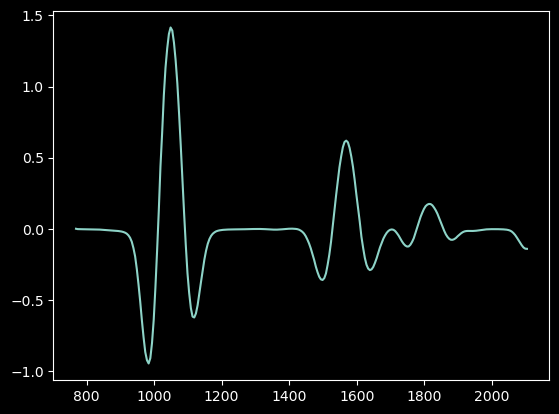

In [11]:
path_sig = "gasx2__msr__"
cm1 = CEPAS_measurement(path, path_sig, col_names)
# cm1.water_plot()
cm1_avg = cm1.avg()
print(cm1_avg.columns)
plt.plot(cm1_avg['offset1'], cm1_avg['H2_pnorm'])
plt.show()


# $p_{cell}\approx600\ \text{[mbar]}$

After closer inspection, seems like in these measurements the power meter was not turned on, so the power normalization is just wrong here

<Figure size 640x480 with 0 Axes>

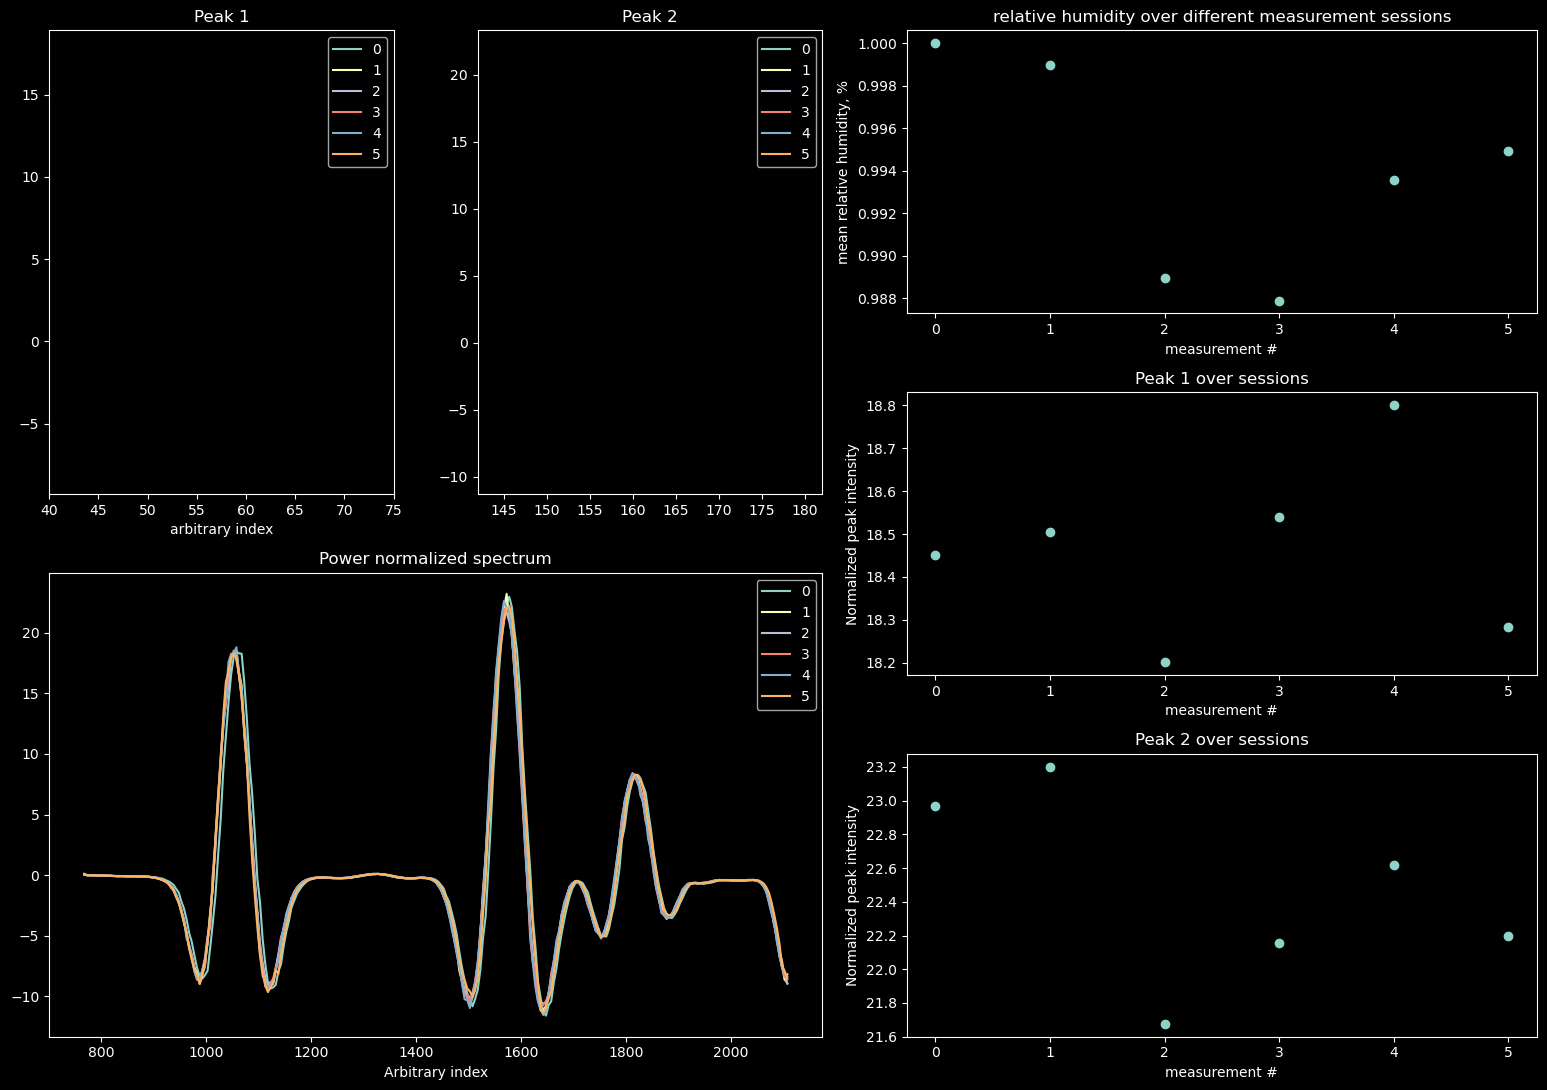

In [12]:
path_sig = "gasx600mbar__msr__"
cm2 = CEPAS_measurement(path, path_sig, col_names)
cm2.water_plot()

In [13]:
cm2.spectra_list[0]

time  offset1   P1        H3            H2     P_las     T_las  \
1    2720.914    768.0  0.0 -0.000061  2.726311e-05 -0.001233  292.2455   
2    2723.023    773.0  0.0  0.000067  9.624281e-06 -0.001233  292.2383   
3    2725.132    778.0  0.0 -0.000015  3.086489e-06 -0.001226  292.2392   
4    2727.237    783.0  0.0  0.000002  9.410022e-07 -0.001219  292.2385   
5    2729.340    788.0  0.0  0.000045  1.849333e-06 -0.001238  292.2407   
..        ...      ...  ...       ...           ...       ...       ...   
265  3384.542   2088.0  0.0  0.000987 -6.414715e-03 -0.001249  292.2231   
266  3386.646   2093.0  0.0  0.001334 -8.102135e-03 -0.001269  292.2290   
267  3388.751   2098.0  0.0  0.001813 -9.388976e-03 -0.001260  292.2339   
268  3390.860   2103.0  0.0  0.001807 -1.076885e-02 -0.001251  292.2345   
269  3392.970   2108.0  0.0  0.001466 -1.119438e-02 -0.001242  292.2296   

           RH  Pressure  time_subtracted  H2_pnorm  H3_pnorm  
1    40.20996     600.0            0.000  0.021520 -0.047832  
2    40.20996     600.0            2.109  0.007597  0.052638  
3    40.18555     600.0            4.218  0.002423 -0.011454  
4    40.18555     600.0            6.323  0.000735  0.001475  
5    40.16113     600.0            8.426  0.001465  0.035961  
..        ...       ...              ...       ...       ...  
265  40.25879     595.0          663.628 -5.127629  0.789028  
266  40.30762     595.0          665.732 -6.583943  1.084011  
267  40.30762     595.0          667.837 -7.573795  1.462784  
268  40.30762     595.0          669.946 -8.623766  1.446961  
269  40.25879     595.0          672.056 -8.899848  1.165565  

[269 rows x 12 columns]

# Amplitude effects (@ $900\ [\text{mbar}]$) [0x20 too low, 0x66 optimal, 0x108 too high]

## Amplitude = 0x20

<Figure size 640x480 with 0 Axes>

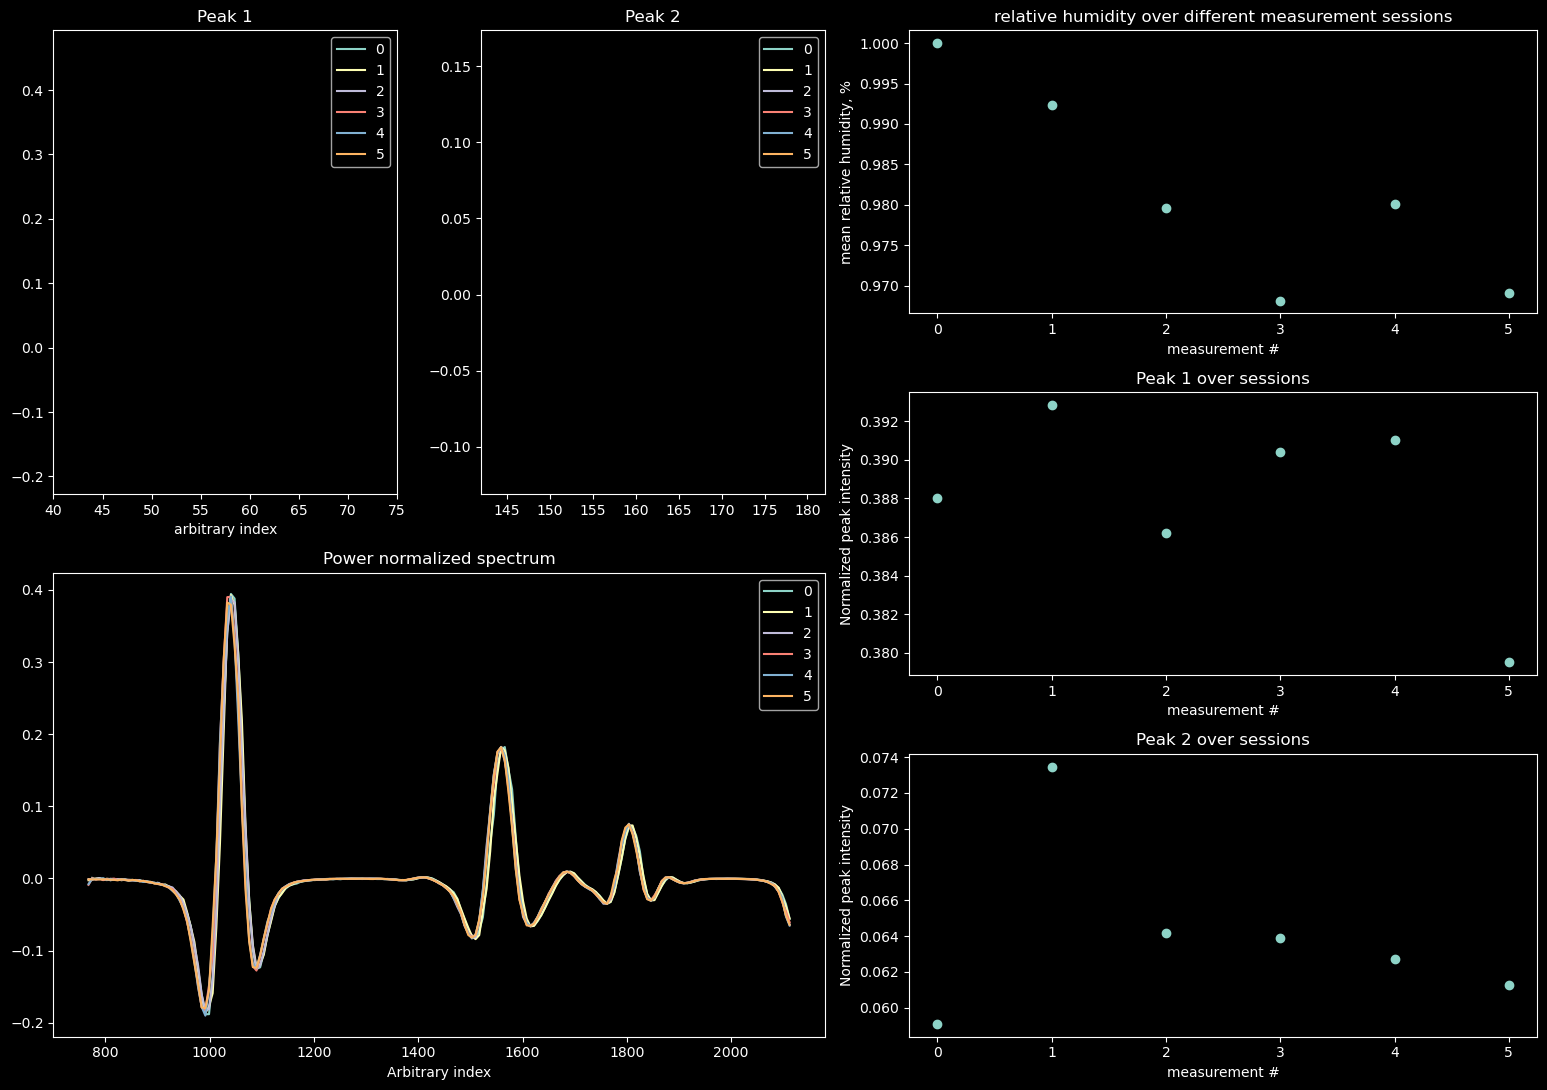

In [14]:
path_sig = "gasx900mbar20amp__msr__"
cm3 = CEPAS_measurement(path, path_sig, col_names)
# len(cm3.spectra_list[0].columns)
cm3.water_plot()


## Amplitude = 66

<Figure size 640x480 with 0 Axes>

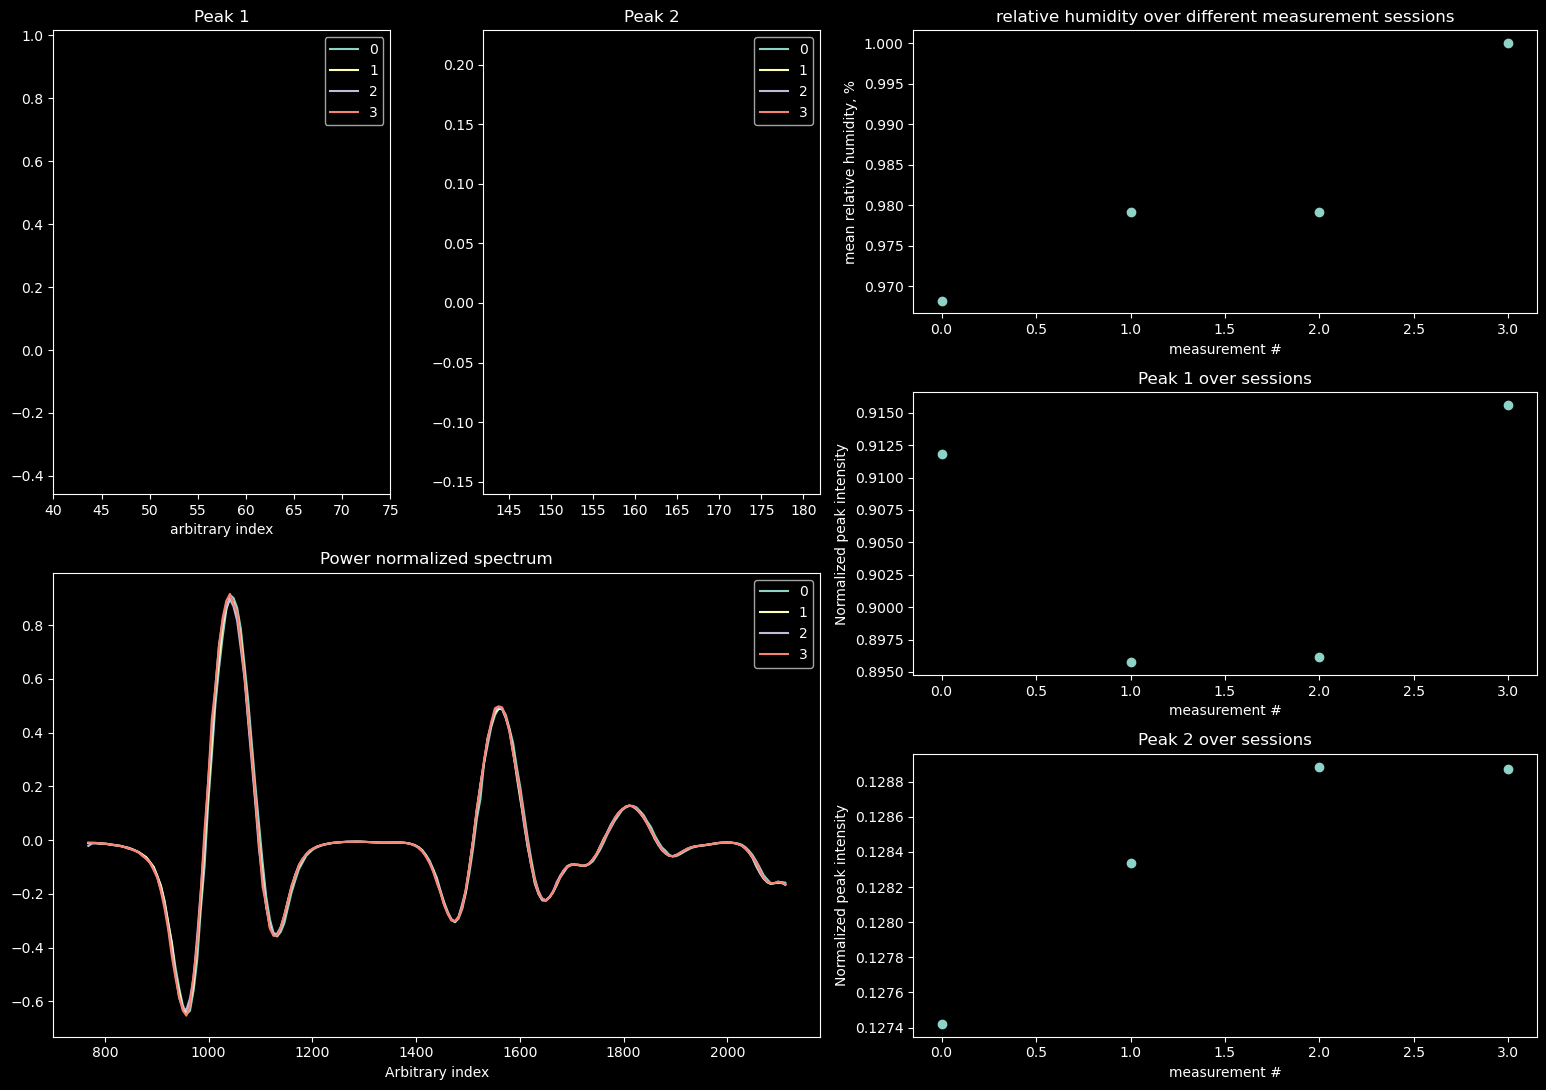

In [15]:
path_sig = "gasx900mbar66amp__msr__"
cm4 = CEPAS_measurement(path, path_sig, col_names)
cm4.water_plot()

## Amplitude 106

In [16]:
path_sig = "gasx900mbar106amp__msr__"
cm5 = CEPAS_measurement(path, path_sig, col_names)
# cm5.water_plot()

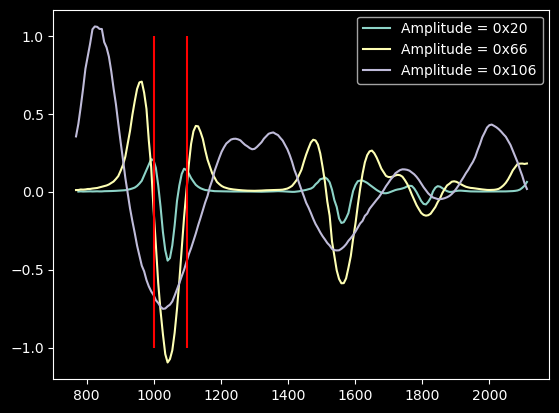

-2.0963459364193224
-1.407104337011501
-0.5346356674952111


In [17]:
plt.plot(cm3.spectra_list[0]["offset1"], cm3.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x20")
plt.plot(cm4.spectra_list[0]["offset1"], cm4.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x66")
plt.plot(cm5.spectra_list[0]["offset1"], cm5.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x106")
# plt.xlim(800, 1200)
plt.vlines([1000, 1100], -1, 1, colors=['red', 'red'])
plt.legend()
plt.show()

print(cm3.spectra_list[0]["H2_pnorm"].max() / cm3.spectra_list[0]["H2_pnorm"].min())
print(cm4.spectra_list[0]["H2_pnorm"].max() / cm4.spectra_list[0]["H2_pnorm"].min())
print(cm5.spectra_list[0]["H2_pnorm"].max() / cm5.spectra_list[0]["H2_pnorm"].min())

## Small amplitude range test

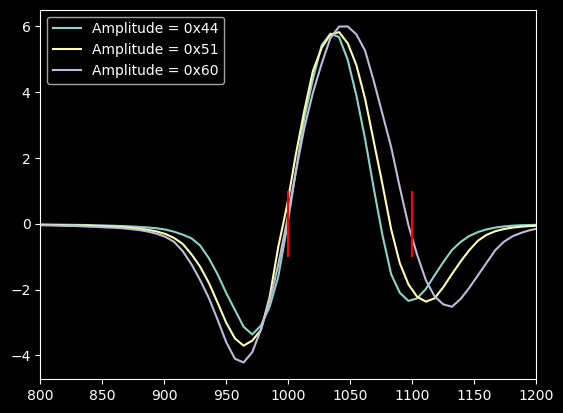

In [18]:
path = './datas/full_tests/'
path_sig = "gasx_600_44_20__msr__"
cm6 = CEPAS_measurement(path, path_sig, col_names)
path_sig = "gasx_600_51_20__msr__"
cm7 = CEPAS_measurement(path, path_sig, col_names)
path_sig = "gasx_600_60_20__msr__"
cm8 = CEPAS_measurement(path, path_sig, col_names)
plt.plot(cm6.spectra_list[0]["offset1"], cm6.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x44")
plt.plot(cm7.spectra_list[0]["offset1"], cm7.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x51")
plt.plot(cm8.spectra_list[0]["offset1"], cm8.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x60")
plt.xlim(800, 1200)
plt.vlines([1000, 1100], -1, 1, colors=['red', 'red'])
plt.legend()
plt.show()

1      False
2      False
3      False
4      False
5      False
       ...  
189    False
190    False
191    False
192    False
193    False
Name: H2_pnorm, Length: 193, dtype: bool


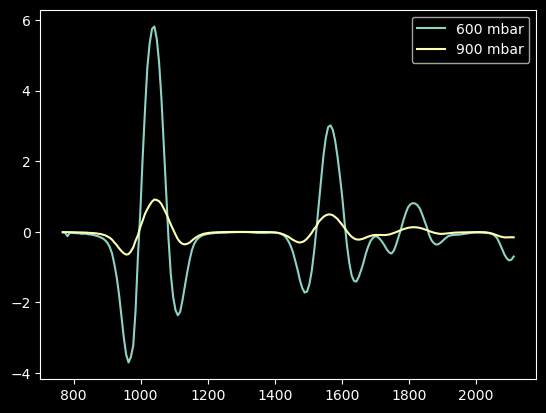

In [19]:
print(cm7.spectra_list[0]["H2_pnorm"] == cm4.spectra_list[0]["H2_pnorm"])
plt.plot(cm7.spectra_list[0]["offset1"], cm7.spectra_list[0]["H2_pnorm"], label="600 mbar")
plt.plot(cm4.spectra_list[0]["offset1"], cm4.spectra_list[0]["H2_pnorm"], label="900 mbar")
plt.legend()
plt.show()


# Auto test

Testing on $\text{H}_2\text{O}$ line in the range

from $6986$ to $6988\ \text{cm}^{-1}$

In [20]:
amp_list = [hex(32+i*8)[2:] for i in range(14)]
print(amp_list)

['20', '28', '30', '38', '40', '48', '50', '58', '60', '68', '70', '78', '80', '88']


In [21]:
offsets_list_h2o_19_deg = [1503.7818, 976.3011] # add lines from the cepas measurement descending
wavenumbers_list_h2o = [6984.9535, 6987.1444] # add lines from trusted source, like HITRAN ascending

fit_params = get_wavenumber(1, offsets_list_h2o_19_deg, wavenumbers_list_h2o)

offset_wav_dict = dict(zip(amp_list, get_modamp_around_line_in_wav(amp_list, offsets_list_h2o_19_deg[0], (fit_params[1], fit_params[2]))))
offset_wav_dict

{'20': 0.13291254068644776,
 '28': 0.16614067585760495,
 '30': 0.19936881102967163,
 '38': 0.23259694620173832,
 '40': 0.2658250813728955,
 '48': 0.2990532165440527,
 '50': 0.3322813517152099,
 '58': 0.3655094868872766,
 '60': 0.39873762205934327,
 '68': 0.43196575723050046,
 '70': 0.46519389240165765,
 '78': 0.49842202757372434,
 '80': 0.531650162745791,
 '88': 0.5648782979169482}

<Figure size 640x480 with 0 Axes>

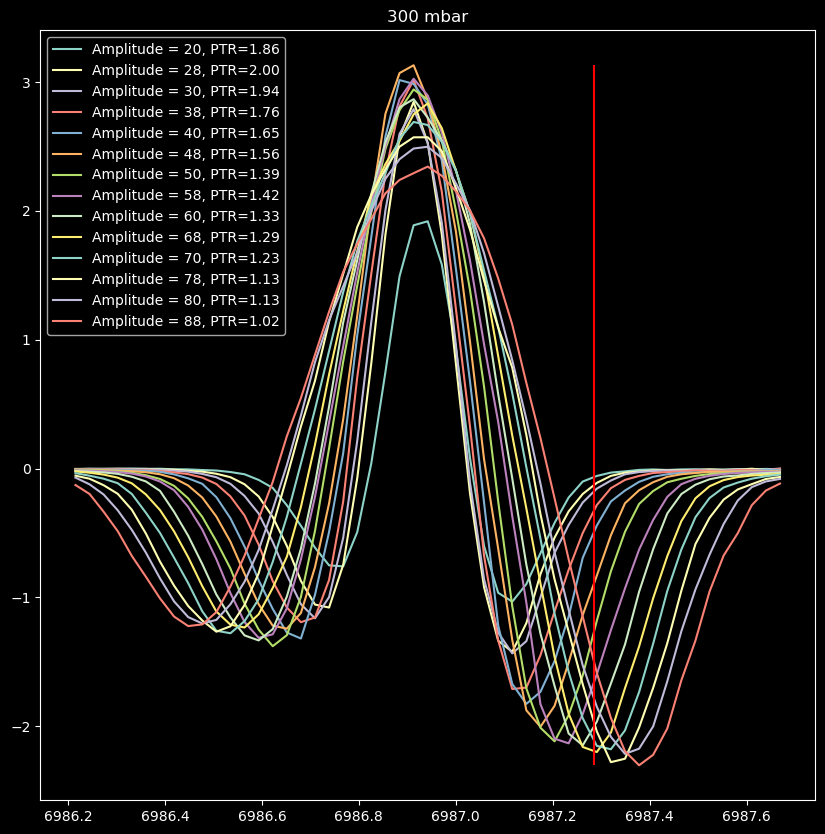

In [22]:
path3 = './datas/amptests/1/'
# amp_list = [hex(8+i*8)[2:] for i in range(14)]
auto_amp_test_300 = {}

amp_test_plot("300", path3, auto_amp_test_300, amp_list, 6987.285, ow_params=(offsets_list_h2o_19_deg, wavenumbers_list_h2o))

In [23]:
path4 = "./datas/amptests/2/"
auto_amp_test_600 = {}


interact_manual(
    amp_test_plot,
    pressure_string=fixed("600"),
    path=fixed(path4),
    amp_test_dict=fixed(auto_amp_test_600),
    used_amps=fixed(amp_list),
    vlinepos=(6986.0, 6987.6, 0.004),
    ow_params=fixed((offsets_list_h2o_19_deg, wavenumbers_list_h2o))
) 
# amp_test_plot(path4, auto_amp_test_600, amp_list, 6987.285)

interactive(children=(FloatSlider(value=6986.8, description='vlinepos', max=6987.6, min=6986.0, step=0.004), B…

<function __main__.amp_test_plot(pressure_string: str | int, path: str, amp_test_dict: Dict, used_amps: Union[List[str], List[int]], vlinepos: float, ow_params: Tuple[List[float], List[float]]) -> None>

<Figure size 640x480 with 0 Axes>

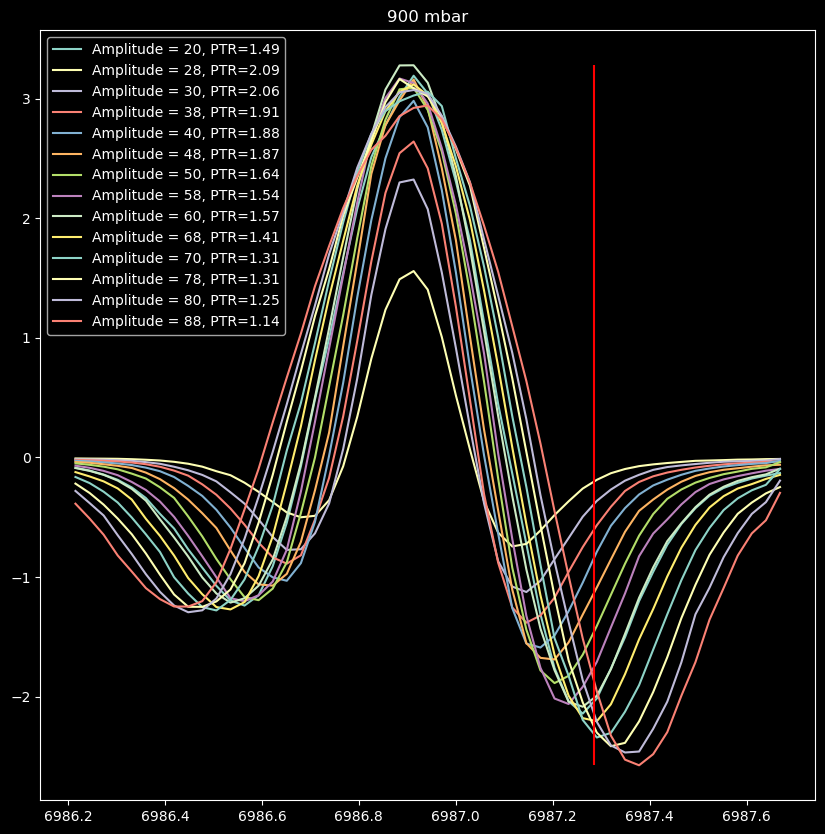

In [24]:
auto_amp_test_900 = {}
# for i in amp_list:
#     # auto_freq_test[f'cm{i}_fl'] = CEPAS_measurement(path=path2, path_signature=f"gasx_600_51_{i}__msr__", cols=col_names)
#     auto_amp_test_900[f'cm{i}_fl'] = CEPAS_measurement(path=path3, path_signature=f"gasx_900_{i}_20__msr__", cols=col_names)
#     auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['wav'] = get_wavenumber(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['offset1'], offsets_list_h2o_19_deg, wavenumbers_list_h2o)
#     min_val = abs(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].min())
#     max_val = abs(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].max())
#     ratio = max_val / min_val
#     # auto_test[f'cm{i}_fl'].water_plot()
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[0]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[0]['RH'], label=f"{i}")
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[1]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[1]['RH'], label=f"{i}")
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[2]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[2]['RH'], label=f"{i}")
#     plt.plot(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['wav'], auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'], label=f'Amplitude = {i}, PTR={ratio:.2f}')
# plt.legend(loc=1)
# plt.title("900 mbar")
# plt.show()

amp_test_plot("900", path3, auto_amp_test_900, amp_list, 6987.285, ow_params=(offsets_list_h2o_19_deg, wavenumbers_list_h2o))

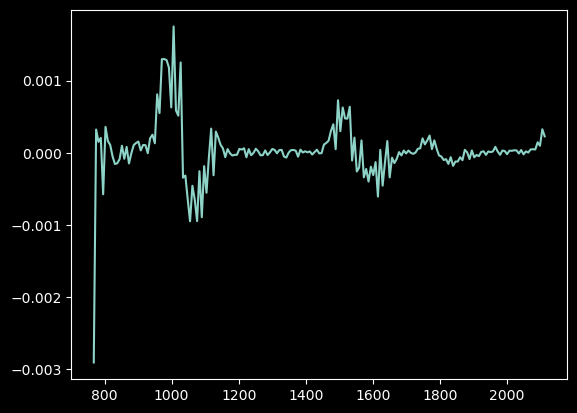

In [25]:
plt.clf()
cm_last = CEPAS_measurement(path=path2, path_signature="gasx_600_51_300__msr__", cols=col_names)
plt.plot(cm_last.spectra_list[0]['offset1'], cm_last.spectra_list[0]['H3_pnorm'])
plt.show()

# Peak/trough ratio

In [26]:
auto_amp_tests = {
    '300': auto_amp_test_300,
    '600': auto_amp_test_600,
    '900': auto_amp_test_900
}



extract_PT_ratios(auto_amp_tests)

300
600
900


{'300': {'Amplitude: cm20_fl': np.float64(1.8572713427997576),
  'Amplitude: cm28_fl': np.float64(2.0008222960484106),
  'Amplitude: cm30_fl': np.float64(1.9438575305495334),
  'Amplitude: cm38_fl': np.float64(1.762320889490436),
  'Amplitude: cm40_fl': np.float64(1.6506866033833827),
  'Amplitude: cm48_fl': np.float64(1.5617129296110441),
  'Amplitude: cm50_fl': np.float64(1.3897437074053178),
  'Amplitude: cm58_fl': np.float64(1.4184613990501653),
  'Amplitude: cm60_fl': np.float64(1.3344244237293932),
  'Amplitude: cm68_fl': np.float64(1.2879978759832391),
  'Amplitude: cm70_fl': np.float64(1.234607380678039),
  'Amplitude: cm78_fl': np.float64(1.1282843521561705),
  'Amplitude: cm80_fl': np.float64(1.1276990716844901),
  'Amplitude: cm88_fl': np.float64(1.0176601718405858)},
 '600': {},
 '900': {'Amplitude: cm20_fl': np.float64(1.48986372048321),
  'Amplitude: cm28_fl': np.float64(2.0936990056230846),
  'Amplitude: cm30_fl': np.float64(2.0649541769237674),
  'Amplitude: cm38_fl': n

# Expt vs Sim analysis

In [27]:
# rows will be 300-600-900 mbar pressures (implicit)
sim = pd.DataFrame({
    "pressure": [300, 600, 900],
    "pos1": [np.nan, 6987.02, 6986.97],
    "pos2": [6987.13, 6987.13, 6987.13],
    "pos3": [6987.23, 6987.25, 6987.3],
    "amp": [0.083, 0.1, 0.1561]
})

expt = pd.DataFrame({
    "pressure": [300, 600, 900],
    "pos1": [6986.691, 6986.78, 6986.616],
    "pos2": [6986.906, 6987.025, 6986.903],
    "pos3": [6987.128, 6987.29, 6987.193],
    "amp": [offset_wav_dict[i] for i in ['38', '40', '48']]
})

sim

pressure     pos1     pos2     pos3     amp
0       300      NaN  6987.13  6987.23  0.0830
1       600  6987.02  6987.13  6987.25  0.1000
2       900  6986.97  6987.13  6987.30  0.1561

/tmp/ipykernel_1997/804583558.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc=3)


<Figure size 640x480 with 0 Axes>

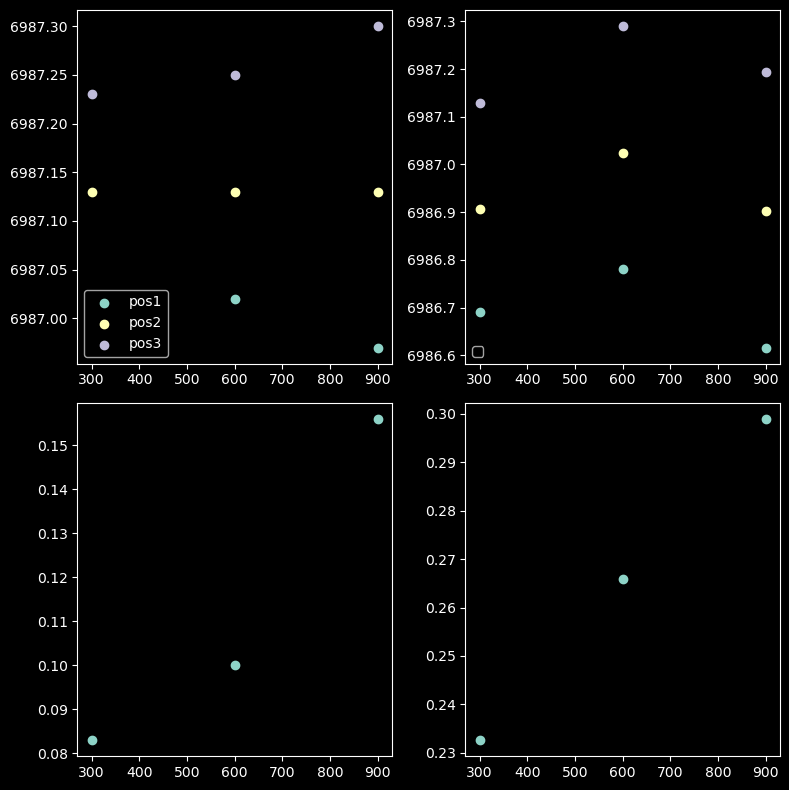

In [28]:
plt.clf()
fig = plt.figure(figsize=(8, 8))  # noqa: F841

ax0 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1, rowspan=1)
for pos in ['pos1', 'pos2', 'pos3']:
    ax0.scatter(sim['pressure'], sim[pos], label=pos)
ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax0.legend(loc=3)

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=1, rowspan=1)
ax1.legend(loc=3)
for pos in ['pos1', 'pos2', 'pos3']:
    ax1.scatter(expt['pressure'], expt[pos], label=pos)

ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), rowspan=1, colspan=1)
ax2.scatter(sim['pressure'], sim['amp'])

ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), rowspan=1, colspan=1)
ax3.scatter(expt['pressure'], expt['amp'])

plt.tight_layout()
plt.show()

In [29]:
# r_o_r_expt = (expt['amp'][2] - expt['amp'][0]) / 600
# r_o_r_sim = (sim['amp'][2] - sim['amp'][0]) / 600
r_o_r_expt = (0.1222-0.042) / 600
r_o_r_sim = (int('0x38', 16) - int('0x28', 16)) / 600

print(f"ROR expt = {r_o_r_expt}")
print(f"ROR sim  = {r_o_r_sim}")

ROR expt = 0.00013366666666666665
ROR sim  = 0.02666666666666667


# $22\ \degree\text{C}$ test

## Initial full spectrums in $p_{cell}=\lbrace 300,600,900\rbrace\ \text{[mbar]}$

<Figure size 640x480 with 0 Axes>

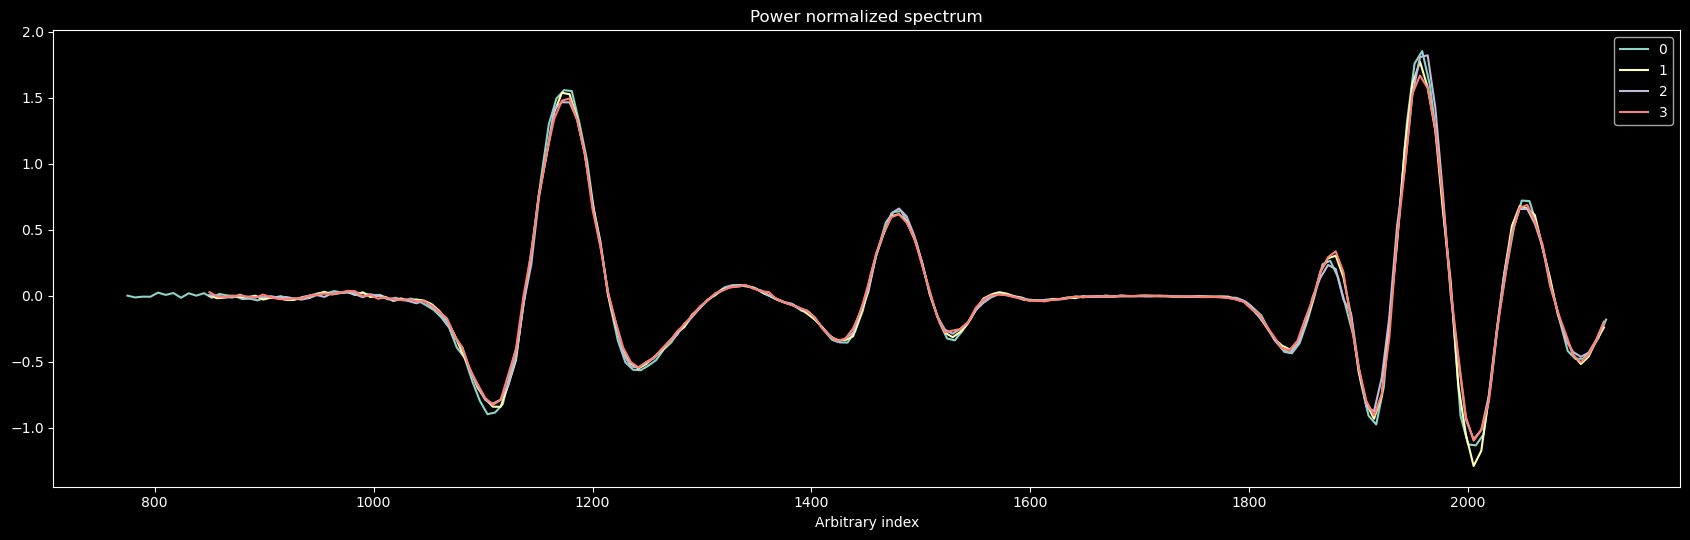

In [30]:
path_22_deg = "./datas/22deg/"
cm_22deg_300 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_300_.+", cols=col_names)
cm_22deg_300.spectrum_only_plot()

<Figure size 640x480 with 0 Axes>

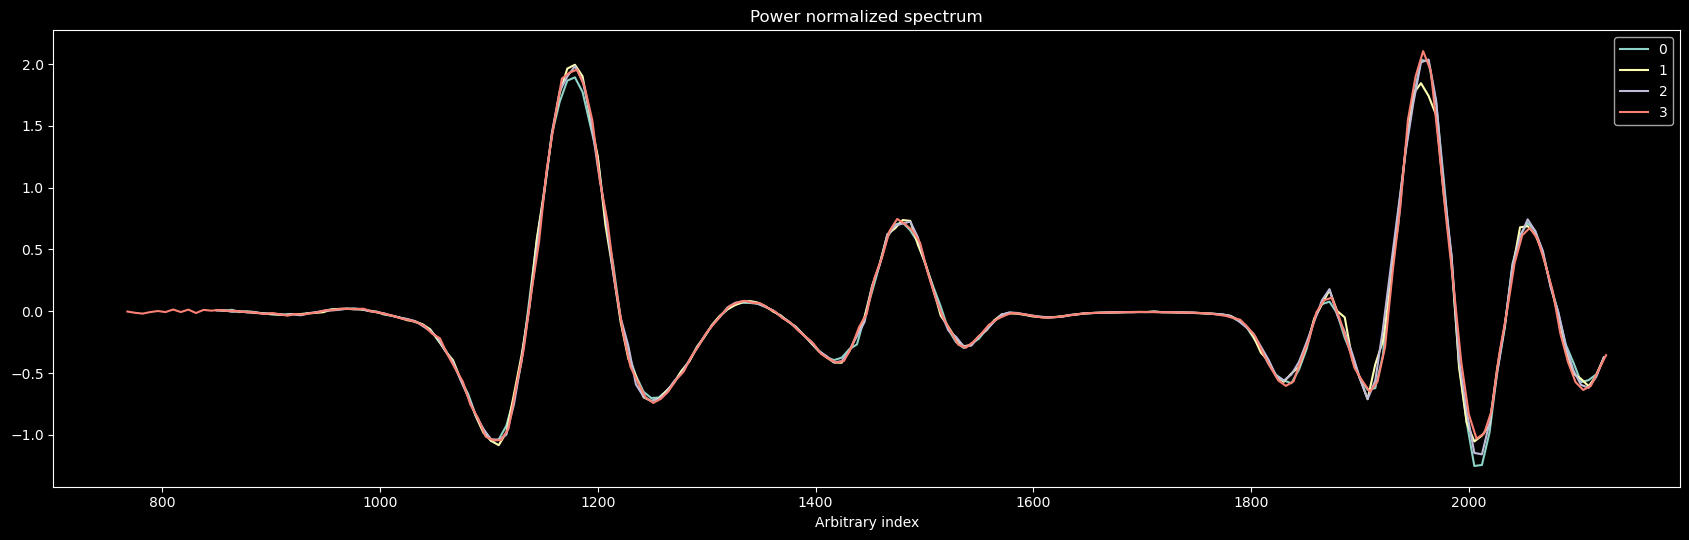

In [31]:
path_22_deg = "./datas/22deg/"
cm_22deg_600 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_600_.+", cols=col_names)
cm_22deg_600.spectrum_only_plot()

# cm_22deg_600.spectra_list[0]

<Figure size 640x480 with 0 Axes>

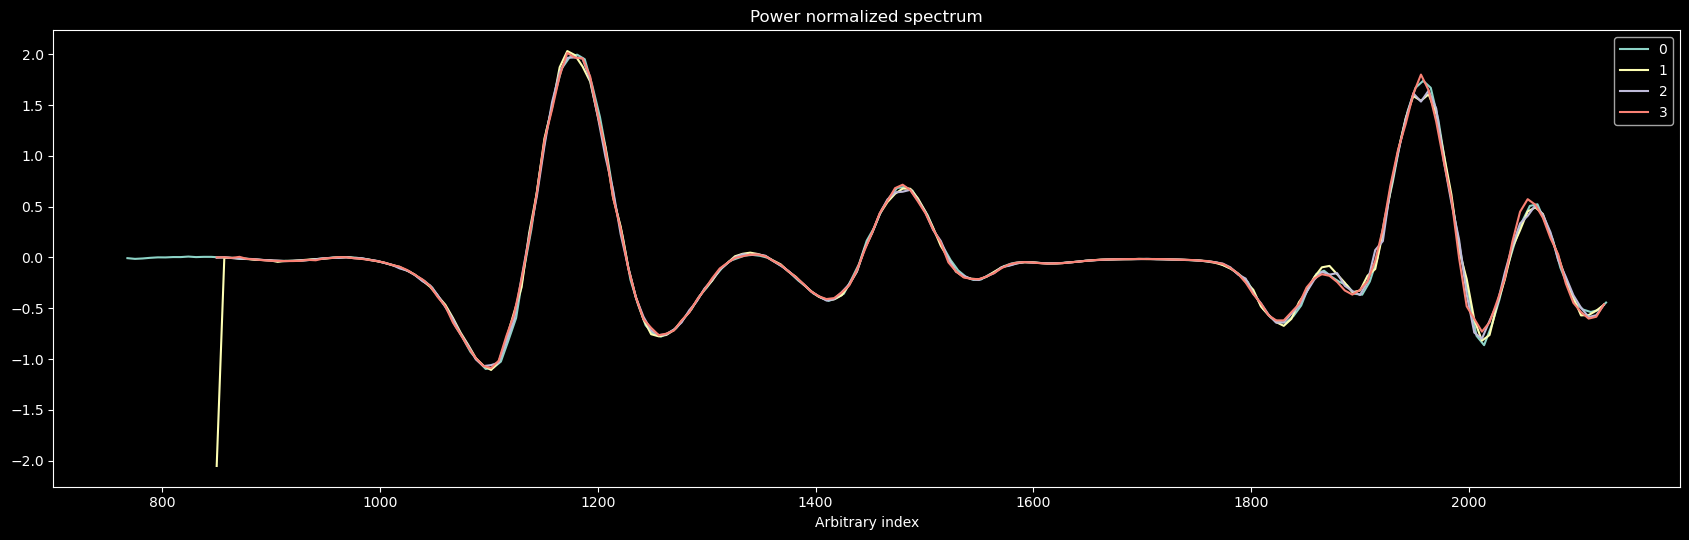

In [32]:
path_22_deg = "./datas/22deg/"
cm_22deg_900 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_900_.+", cols=col_names)
cm_22deg_900.spectrum_only_plot()

## Modulation amplitude test for line $\tilde{\nu}_{\text{H}_2\text{O}}=6983.6678\ \text{cm}^{-1}$

<Figure size 640x480 with 0 Axes>

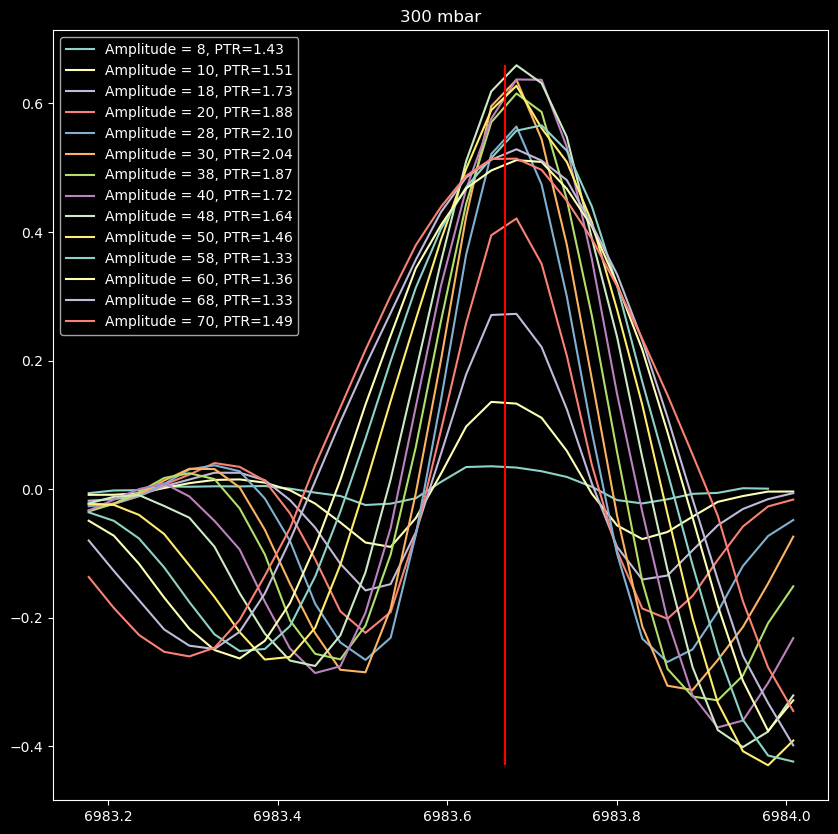

time  offset1   P1        H3        H2     P_las     T_las        RH  \
1   692.030   1400.0  0.0 -0.000295 -0.000355  0.090616  295.1961  26.00098   
2   693.132   1407.0  0.0 -0.000330 -0.000366  0.091319  295.2094  26.00098   
3   694.237   1414.0  0.0 -0.000806 -0.001018  0.091428  295.1972  26.00098   
4   695.341   1421.0  0.0 -0.001261 -0.001873  0.091594  295.2020  26.00098   
5   696.447   1428.0  0.0 -0.002533 -0.004061  0.092134  295.1947  26.00098   
6   697.549   1435.0  0.0 -0.004007 -0.006343  0.092527  295.1940  26.00098   
7   698.654   1442.0  0.0 -0.005324 -0.007416  0.092858  295.1913  26.00098   
8   699.759   1449.0  0.0 -0.003673 -0.005397  0.092917  295.2010  26.00098   
9   700.860   1456.0  0.0 -0.000165 -0.000716  0.093110  295.2087  26.00098   
10  701.965   1463.0  0.0  0.003752  0.005712  0.093477  295.2045  26.00098   
11  717.712   1470.0  0.0  0.007216  0.010742  0.094437  295.1940  26.00098   
12  718.815   1477.0  0.0  0.009345  0.012881  0.094385  295.1927  26.00098   
13  719.920   1484.0  0.0  0.009591  0.013263  0.095283  295.2033  26.00098   
14  721.023   1491.0  0.0  0.007292  0.009704  0.097260  295.2032  25.97656   
15  722.125   1498.0  0.0  0.001678  0.002398  0.098097  295.2078  25.97656   
16  723.232   1505.0  0.0 -0.003102 -0.004595  0.099357  295.1941  25.97656   
17  724.337   1512.0  0.0 -0.006002 -0.009277  0.100576  295.1983  25.97656   
18  725.439   1519.0  0.0 -0.005850 -0.008687  0.101966  295.1877  25.97656   
19  726.542   1526.0  0.0 -0.004368 -0.005497  0.103392  295.1951  25.97656   
20  727.648   1533.0  0.0 -0.001851 -0.002427  0.104805  295.1982  25.97656   
21  728.753   1540.0  0.0 -0.000360 -0.000201  0.106304  295.2045  25.97656   
22  729.756   1547.0  0.0  0.000341  0.001099  0.107370  295.2080  25.97656   
23  730.861   1554.0  0.0  0.000798  0.001678  0.109211  295.1938  25.97656   
24  731.966   1561.0  0.0  0.001305  0.001634  0.112410  295.2023  25.97656   
25  733.070   1568.0  0.0  0.000569  0.001077  0.114403  295.2058  25.97656   
26  734.172   1575.0  0.0 -0.000017  0.000190  0.115530  295.2089  25.97656   
27  749.836   1582.0  0.0 -0.000873 -0.000781  0.117861  295.1938  25.97656   
28  751.038   1589.0  0.0 -0.000657 -0.001081  0.119851  295.1998  25.92773   
29  752.043   1596.0  0.0 -0.000604 -0.001112  0.121769  295.1943  25.92773   

    Pressure  time_subtracted  H2_pnorm  H3_pnorm  
1      299.0            0.000 -0.003810 -0.003166  
2      299.0            1.102 -0.003900 -0.003520  
3      299.0            2.207 -0.010839 -0.008582  
4      299.0            3.311 -0.019904 -0.013401  
5      299.0            4.417 -0.042917 -0.026768  
6      299.0            5.519 -0.066752 -0.042171  
7      299.0            6.624 -0.077772 -0.055828  
8      299.0            7.729 -0.056564 -0.038498  
9      299.0            8.830 -0.007489 -0.001723  
10     299.0            9.935  0.059514  0.039091  
11     297.0           25.682  0.110819  0.074443  
12     297.0           26.785  0.132948  0.096455  
13     297.0           27.890  0.135634  0.098083  
14     297.0           28.993  0.097273  0.073093  
15     297.0           30.095  0.023835  0.016683  
16     297.0           31.202 -0.045115 -0.030459  
17     297.0           32.307 -0.090002 -0.058229  
18     297.0           33.409 -0.083152 -0.056000  
19     297.0           34.512 -0.051910 -0.041252  
20     297.0           35.618 -0.022622 -0.017248  
21     297.0           36.723 -0.001850 -0.003306  
22     297.0           37.726  0.010005  0.003103  
23     297.0           38.831  0.015021  0.007144  
24     297.0           39.936  0.014220  0.011353  
25     297.0           41.040  0.009216  0.004869  
26     297.0           42.142  0.001613 -0.000144  
27     299.0           57.806 -0.006487 -0.007256  
28     299.0           59.008 -0.008836 -0.005367  
29     299.0           60.013 -0.008949 -0.004860

In [33]:
offsets = [1480.3, 1177.2]
wavenumbers = [6983.6678, 6984.9534710]

path_6983_6678_300 = "./datas/amptests/h2o_6983_6678/1/"
amp_test_6983_6678_300_dict = {}
amp_list = [hex(8+i*8)[2:] for i in range(14)]
amp_test_plot("300", path_6983_6678_300, amp_test_6983_6678_300_dict, amp_list, 6983.6678, ow_params=(offsets, wavenumbers))
cm_new_line_300 = CEPAS_measurement(path=path_6983_6678_300, path_signature="gasx_300.+", cols=col_names)
cm_new_line_300.spectra_list[0]

## Different pressure spectra overlaid (width comparison)

#### Same RH%, diff pressures

       time  offset1   P1        H3        H2     P_las     T_las        RH  \
1  2322.939    768.0  0.0  0.000043  0.000297  0.016986  295.1931  23.19336   
2  2324.042    775.0  0.0 -0.000077 -0.000074  0.016982  295.1858  23.19336   
3  2325.145    782.0  0.0 -0.000208  0.000027  0.018738  295.1790  23.19336   
4  2326.347    789.0  0.0 -0.000011 -0.000107  0.019990  295.2006  23.19336   
5  2327.348    796.0  0.0  0.000016 -0.000004  0.020634  295.1872  23.19336   

   Pressure  time_subtracted  H2_pnorm  H3_pnorm  
1     298.0            0.000  0.015251  0.002219  
2     298.0            1.103 -0.003820 -0.003947  
3     298.0            2.206  0.001282 -0.009800  
4     298.0            3.408 -0.004736 -0.000492  
5     298.0            4.409 -0.000185  0.000710  


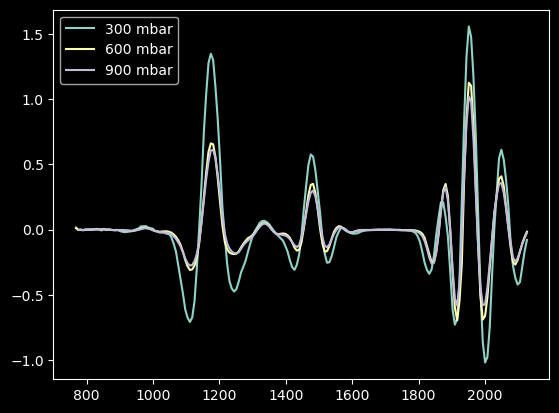

In [34]:
path_pressure_tests_1 = './datas/amptests/h2o_6983_6678/p_tests/1/'
prs_sig_300 = r'gasx_300_.+'
prs_sig_600 = r'gasx_600_.+'
prs_sig_900 = r'gasx_900_.+'
cm300 = CEPAS_measurement(path_pressure_tests_1, prs_sig_300, col_names)
cm600 = CEPAS_measurement(path_pressure_tests_1, prs_sig_600, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_1, prs_sig_900, col_names)
print(cm300.spectra_list[0].head())
plt.plot(cm300.spectra_list[0]['offset1'], cm300.spectra_list[0]['H2_pnorm'], label="300 mbar")
plt.plot(cm600.spectra_list[0]['offset1'], cm600.spectra_list[0]['H2_pnorm'], label="600 mbar")
plt.plot(cm900.spectra_list[0]['offset1'], cm900.spectra_list[0]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()

#### Diff pressures, diff RH ($p_{cell}=300\ \text{[mbar]}/RH=10\%$ and $p_{cell}=900\ \text{[mbar]}/RH=37\%$)

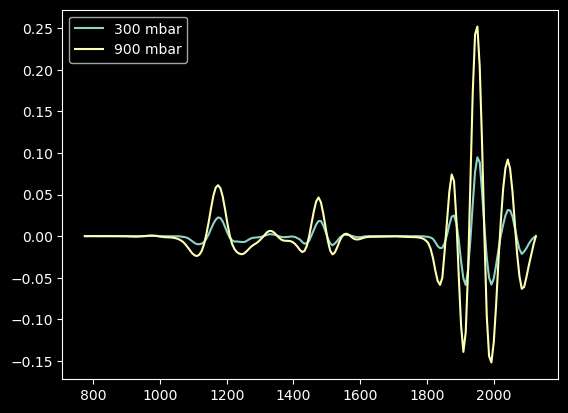

In [35]:
path_pressure_tests_2 = './datas/amptests/h2o_6983_6678/p_tests/2/'
cm300 = CEPAS_measurement(path_pressure_tests_2, prs_sig_300, col_names)
# cm600 = CEPAS_measurement(path_pressure_tests_2, prs_sig_600, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_2, prs_sig_900, col_names)
plt.plot(cm300.spectra_list[0]['offset1'], cm300.spectra_list[0]['H2'], label="300 mbar")
plt.plot(cm900.spectra_list[0]['offset1'], cm900.spectra_list[0]['H2'], label="900 mbar")
plt.legend()
plt.show()

## Amplitude modulation / Chopper

#### Bad chopper run

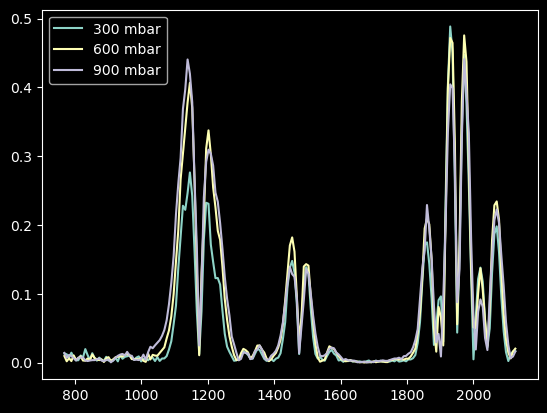

In [36]:
path_pressure_tests_4 = './datas/amptests/h2o_6983_6678/p_tests/4/'
cm300 = CEPAS_measurement(path_pressure_tests_4, prs_sig_300, col_names)
cm600 = CEPAS_measurement(path_pressure_tests_4, prs_sig_600, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_4, prs_sig_900, col_names)
cols = list(cm300.spectra_list[0].columns)
plt.plot(cm300.spectra_list[2]['offset1'], cm300.spectra_list[2]['H2_pnorm'], label="300 mbar")
plt.plot(cm600.spectra_list[2]['offset1'], cm600.spectra_list[2]['H2_pnorm'], label="600 mbar")
plt.plot(cm900.spectra_list[2]['offset1'], cm900.spectra_list[2]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()

#### Diff pressures w/ chopper

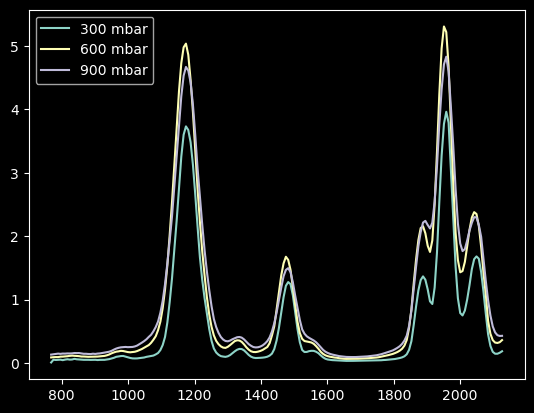

In [37]:
path_pressure_tests_5 = './datas/amptests/h2o_6983_6678/p_tests/5/'
cm300 = CEPAS_measurement(path_pressure_tests_5, prs_sig_300, col_names)
cm600 = CEPAS_measurement(path_pressure_tests_5, prs_sig_600, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_5, prs_sig_900, col_names)
cols = list(cm300.spectra_list[0].columns)
plt.plot(cm300.spectra_list[1]['offset1'], cm300.spectra_list[1]['H2_pnorm'], label="300 mbar")
plt.plot(cm600.spectra_list[1]['offset1'], cm600.spectra_list[1]['H2_pnorm'], label="600 mbar")
plt.plot(cm900.spectra_list[1]['offset1'], cm900.spectra_list[1]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()

#### Low humidity test

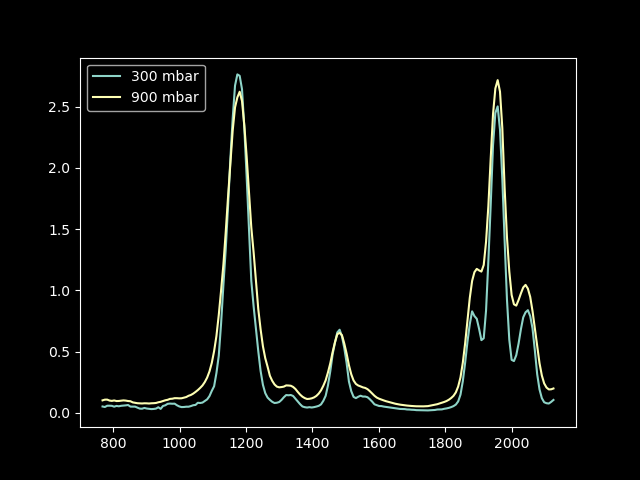

-0.004233358577542437
6989.936134045767


In [38]:
%matplotlib widget
plt.clf()
units1 = [1480.7, 1177.0] # offsets decimal
units2 = [6983.6678, 6984.9534710] # wavenumbers
a = get_wavenumber(1, units1, units2)[1]
b = get_wavenumber(1, units1, units2)[2]
path_pressure_tests_6 = './datas/amptests/h2o_6983_6678/p_tests/lowRH/'
cm300 = CEPAS_measurement(path_pressure_tests_6, prs_sig_300, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_6, prs_sig_900, col_names)
cols = list(cm300.spectra_list[0].columns)
# plt.plot(a*cm300.spectra_list[0]['offset1']+b, cm300.spectra_list[0]['H2_pnorm'], label="300 mbar")
# plt.plot(a*cm900.spectra_list[0]['offset1']+b, cm900.spectra_list[0]['H2_pnorm'], label="900 mbar")
plt.plot(cm300.spectra_list[0]['offset1'], cm300.spectra_list[0]['H2_pnorm'], label="300 mbar")
plt.plot(cm900.spectra_list[0]['offset1'], cm900.spectra_list[0]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()
print(a)
print(b)

#### Low RH test, 300, 600, 900 mbar

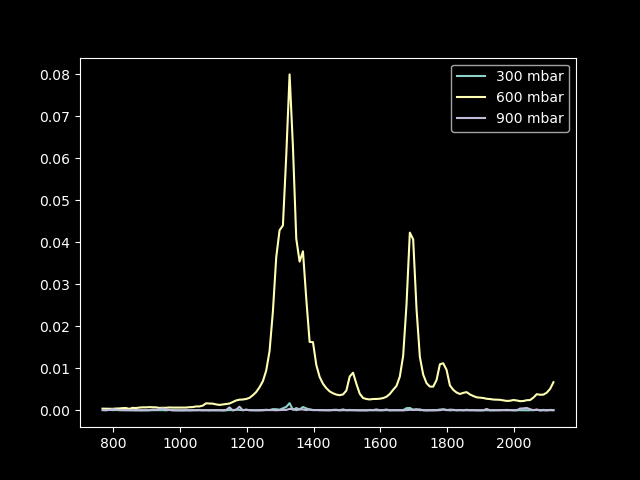

-0.004233358577542437
6989.936134045767


In [39]:
plt.clf()
units1 = [1480.7, 1177.0] # offsets decimal
units2 = [6983.6678, 6984.9534710] # wavenumbers
a = get_wavenumber(1, units1, units2)[1]
b = get_wavenumber(1, units1, units2)[2]
path_pressure_tests_7 = './datas/amptests/h2o_6983_6678/p_tests/lowRH_picoSignal/'
cm300_7 = CEPAS_measurement(path_pressure_tests_7, prs_sig_300, col_names)
cm600_7 = CEPAS_measurement(path_pressure_tests_7, prs_sig_600, col_names)
cm900_7 = CEPAS_measurement(path_pressure_tests_7, prs_sig_900, col_names)
cols = list(cm300_7.spectra_list[0].columns)
# plt.plot(a*cm300_7.spectra_list[0]['offset1']+b, cm300_7.spectra_list[0]['H2'], label="300 mbar")
plt.plot(cm300_7.spectra_list[1]['offset1'], cm300_7.spectra_list[1]['H2'], label="300 mbar")
plt.plot(cm600_7.spectra_list[0]['offset1'], cm600_7.spectra_list[0]['H2'], label="600 mbar")
plt.plot(cm900_7.spectra_list[0]['offset1'], cm900_7.spectra_list[0]['H2'], label="900 mbar")
plt.legend()
plt.show()
print(a)
print(b)

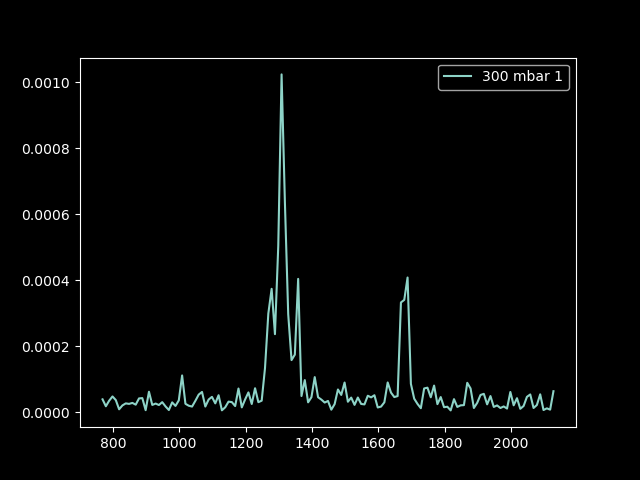

In [40]:
plt.clf()
path_pressure_tests_8 = './datas/amptests/h2o_6983_6678/p_tests/picoSignal_newLoop/'
cm300_8 = CEPAS_measurement(path_pressure_tests_8, prs_sig_300, col_names)
cols = list(cm300_8.spectra_list[0].columns)
plt.plot(cm300_8.spectra_list[0]['offset1'], cm300_8.spectra_list[0]['H2'], label="300 mbar 1")
# plt.plot(cm300_8.spectra_list[1]['offset1'], cm300_8.spectra_list[1]['H2'], label="300 mbar 2")
# plt.plot(cm300_8.spectra_list[2]['offset1'], cm300_8.spectra_list[2]['H2'], label="300 mbar 3")
plt.legend()
plt.show()

#### Good chopper runs (correct frequency $\approx 84\ \text{Hz}$)

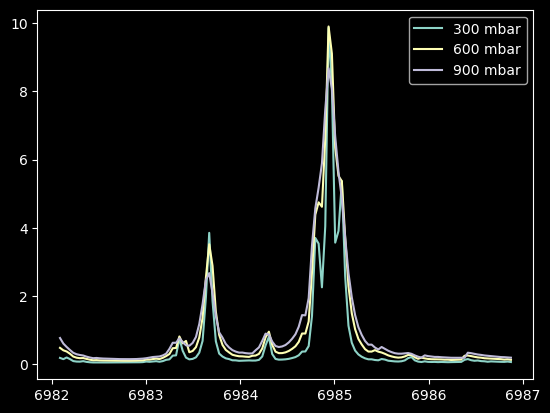

-0.0035223863013688714
6989.580829884108


In [41]:

%matplotlib inline
plt.clf()
units1 = [1678.7, 1313.7] # offsets decimal
units2 = [6983.6678, 6984.9534710] # wavenumbers
a = get_wavenumber(1, units1, units2)[1]
b = get_wavenumber(1, units1, units2)[2]
path_pressure_tests_9 = './datas/amptests/h2o_6983_6678/p_tests/33RH_84Hz_chopper_correct/'
cm300_9 = CEPAS_measurement(path_pressure_tests_9, prs_sig_300, col_names)
cm600_9 = CEPAS_measurement(path_pressure_tests_9, prs_sig_600, col_names)
cm900_9 = CEPAS_measurement(path_pressure_tests_9, prs_sig_900, col_names)
# line_300_9 = get_range(cm300_9.spectra_list[0], 'offset1', 6983.5, 6983.9)
# line_600_9 = get_range(cm600_9.spectra_list[0], 'offset1', 6983.5, 6983.9)
# line_900_9 = get_range(cm900_9.spectra_list[0], 'offset1', 6983.5, 6983.9)
# cols = list(cm300_7.spectra_list[0].columns)
# plt.plot(cm300_9.spectra_list[1]['offset1'], cm300_9.spectra_list[1]['H2_pnorm'], label="300 mbar")
# plt.plot(cm600_9.spectra_list[0]['offset1'], cm600_9.spectra_list[0]['H2_pnorm'], label="600 mbar")
# plt.plot(cm900_9.spectra_list[0]['offset1'], cm900_9.spectra_list[0]['H2_pnorm'], label="900 mbar")
plt.plot(a*cm300_9.spectra_list[2]['offset1']+b, cm300_9.spectra_list[2]['H2_pnorm'], label="300 mbar")
plt.plot(a*cm600_9.spectra_list[2]['offset1']+b, cm600_9.spectra_list[2]['H2_pnorm'], label="600 mbar")
plt.plot(a*cm900_9.spectra_list[2]['offset1']+b, cm900_9.spectra_list[2]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()
print(a)
print(b)

#### Current -> offsets -> wavenumbers

We can convert from current to offsets. And from offsets to wavenumbers.

Then we convert from current to wavenumbers.

`get_wavenumber()` is general enough, lets go to lab

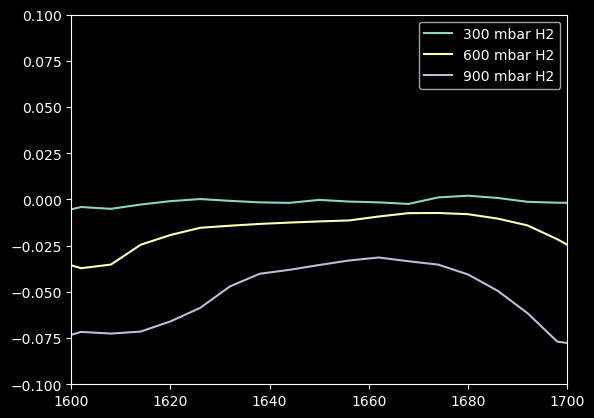

In [42]:
plt.clf()
path_pressure_tests_10 = './datas/FilteredSignal/2/'
cm300_10 = CEPAS_measurement(path_pressure_tests_10, prs_sig_300, col_names)
cm600_10 = CEPAS_measurement(path_pressure_tests_10, prs_sig_600, col_names)
cm900_10 = CEPAS_measurement(path_pressure_tests_10, prs_sig_900, col_names)
cols = list(cm300_10.spectra_list[0].columns)
plt.plot(cm300_10.spectra_list[0]['offset1'], cm300_10.spectra_list[0]['H2_pnorm'], label="300 mbar H2")
# plt.plot(cm300_10.spectra_list[1]['offset1'], cm300_10.spectra_list[1]['H2_pnorm'], label="300 mbar H2")
plt.plot(cm600_10.spectra_list[0]['offset1'], cm600_10.spectra_list[0]['H2_pnorm'], label="600 mbar H2")
# plt.plot(cm600_10.spectra_list[1]['offset1'], cm300_10.spectra_list[1]['H2_pnorm'], label="300 mbar H2")
plt.plot(cm900_10.spectra_list[0]['offset1'], cm900_10.spectra_list[0]['H2_pnorm'], label="900 mbar H2")
# plt.plot(cm900_10.spectra_list[1]['offset1'], cm900_10.spectra_list[1]['H2_pnorm'], label="900 mbar H2")
plt.vlines([1440], ymin=-0.2, ymax=0.2, colors=['red'])
plt.legend()
plt.xlim((1600, 1700))
plt.ylim(-0.1, 0.1)
plt.show()

# For microphone noise spectra (acoustic freq)

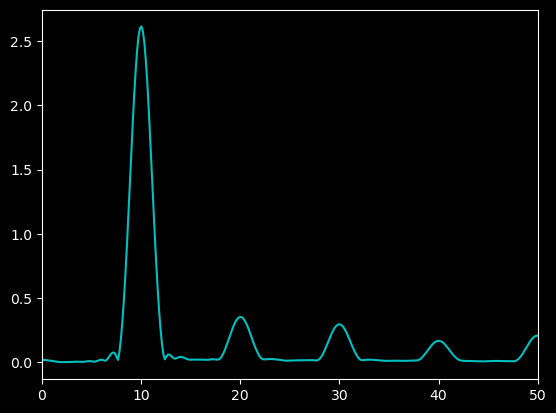

In [43]:
%matplotlib inline
noise_path = './datas/noise_tests/spectrum_20082025'
noise_x10_avg = './datas/noise_tests/spectrum_21082025_0_x10'
noise_x10_avg_84Hz = './datas/noise_tests/spectrum_21082025_0_x10_84Hz'
noise_x10_avg_84Hz_gasx_RH35 = './datas/noise_tests/spectrum_21082025_0_x10_84Hz_gasx_RH35'
# df = pd.read_csv(noise_path, sep=r'\s+', header=None, names=['freq', 'intensity'])
df = pd.read_csv(noise_x10_avg, sep=r'\s+', header=None, names=['freq', 'intensity'])
# df = pd.read_csv(noise_x10_avg_84Hz, sep=r'\s+', header=None, names=['freq', 'intensity'])
# df = pd.read_csv(noise_x10_avg_84Hz_gasx_RH35, sep=r'\s+', header=None, names=['freq', 'intensity'])
plt.plot(df['freq'], df['intensity'], 'c-')
plt.xlim(0, 50)
plt.show()

# Benchmark #1

First, we establish the paths of the noise and measurement data directories:

In [44]:
benchmark_path = "./datas/benchmark/measurements/"
benchmark_noise = "./datas/benchmark/noise/"

Now, we need to figure out the grouping, the most efficient way to display the results. Used frequencies are
$
\begin{equation}
f \in \left\{20, 30, 40, 80, 90, 130, 170, 220, 300\right\}\ \left[\text{Hz}\right],
\end{equation}
$

In [45]:
freq_list_2 = [20, 30, 40, 80, 90, 130, 170, 220, 300]


and we have three measurements of each frequency, at three different pressures, namely:
$
\begin{equation}
p \in \left\{300,600,900\right\}\ \left[\text{mbar}\right]
\end{equation}
$


In [46]:
pressure_list = [300, 600, 900]

So the total amount of measurements is $n = 3\times9\times3=27\times3$. Of each $p$ and $f$, those three measurements are meant to be averaged.
And the top three points (peak, left to peak and right to peak) are meant to be fit to some arbitrary function (for example spline or some
gaussian-like function). Physicality here is not as important as consistency throughout the analysis.

Also, need to determine the noise from some relatively flat region in the spectrum.

Also, need to create wavenumber axis for the all the spectra.

In [47]:
patterns = create_regex_strings(pressure_list, freq_list_2)

test_bench_files = dir_match_dict(benchmark_path, patterns) 
pp.pprint(patterns)
pp.pprint(test_bench_files)

{300: {20: re.compile('gasx_300_(12|24|32)_20__msr__[0-9]{1,2}'),
       30: re.compile('gasx_300_(12|24|32)_30__msr__[0-9]{1,2}'),
       40: re.compile('gasx_300_(12|24|32)_40__msr__[0-9]{1,2}'),
       80: re.compile('gasx_300_(12|24|32)_80__msr__[0-9]{1,2}'),
       90: re.compile('gasx_300_(12|24|32)_90__msr__[0-9]{1,2}'),
       130: re.compile('gasx_300_(12|24|32)_130__msr__[0-9]{1,2}'),
       170: re.compile('gasx_300_(12|24|32)_170__msr__[0-9]{1,2}'),
       220: re.compile('gasx_300_(12|24|32)_220__msr__[0-9]{1,2}'),
       300: re.compile('gasx_300_(12|24|32)_300__msr__[0-9]{1,2}')},
 600: {20: re.compile('gasx_600_(12|24|32)_20__msr__[0-9]{1,2}'),
       30: re.compile('gasx_600_(12|24|32)_30__msr__[0-9]{1,2}'),
       40: re.compile('gasx_600_(12|24|32)_40__msr__[0-9]{1,2}'),
       80: re.compile('gasx_600_(12|24|32)_80__msr__[0-9]{1,2}'),
       90: re.compile('gasx_600_(12|24|32)_90__msr__[0-9]{1,2}'),
       130: re.compile('gasx_600_(12|24|32)_130__msr__[0-9]{1,2}'),

 We have done some data logistics, now, for the flow of analysis.

 For each pressure/frequency:

1) Get those three measurements into `CEPAS_measurement` object DONE

2) Apply averaging DONE

3) Add wavenumber axis DONE

4) Find the test peak DONE

5) Do the fit for those top 3 peak points, determine __peak height__ DONE

6) Determine the noise at some flat region DONE

7) Determine the SNR (signal to noise ratio) DONE

8) Make some automation to do this for any number of different measurements DONE

## Work on spectra

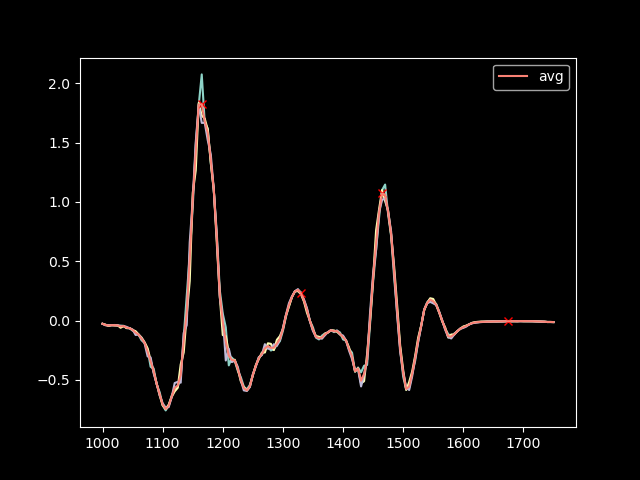

In [196]:
u1 = [1158.9, 1452.0]
u2 = [6984.9534710, 6983.6678]

class CEPAS_benchmark():
    def __init__(self, path, spectra_names: Dict[int, Dict[int, List[str]]], pressure, frequency) -> None:
        self.path = path
        self.spectra_names = spectra_names[pressure][frequency]
        self.pressure = pressure
        self.frequency = frequency
        self.spectra = CEPAS_measurement(
            path=path,
            path_signature=f"gasx_{pressure}_[0-9]{{2}}_{frequency}.+",
            cols=col_names)
        
        # workaround for uneven spectra
        neq_12 = len(self.spectra.spectra_list[0]) != len(self.spectra.spectra_list[1])
        neq_23 = len(self.spectra.spectra_list[1]) != len(self.spectra.spectra_list[2])
        # neq_13 = len(self.spectra.spectra_list[2]) != len(self.spectra.spectra_list[0])

        if neq_12:
            self.spectra.replace(1, self.spectra.spectra_list[1].iloc[1:].reset_index(drop=True))
            self.spectra.replace(2, self.spectra.spectra_list[2].iloc[1:].reset_index(drop=True))
            self.spectra.replace(0, self.spectra.spectra_list[0].reset_index(drop=True))
        
        if neq_23:
            self.spectra.replace(0, self.spectra.spectra_list[0].iloc[1:].reset_index(drop=True))
            self.spectra.replace(1, self.spectra.spectra_list[1].iloc[1:].reset_index(drop=True))
            self.spectra.replace(2, self.spectra.spectra_list[2].reset_index(drop=True))

        # print(self.spectra.spectra_list)

    def get_avg(self):
        return self.spectra.avg()

    def add_wav(self, units1, units2):
        for s in self.spectra.spectra_list:
            s['wavenumbers'] = self.spectra.get_wavenumber(s['offset1'], units1, units2)[0]

    def self_test(self):
        test_string = f"""\
        ------------Benchmark test-------------
        Path: {bench_test.path}
        File names:\n\t{bench_test.spectra_names}
        pressure: {self.pressure} mbar
        frequency: {self.frequency} Hz
        spectra_list: {self.spectra.spectra_list}
        ----------------END--------------------
        """
        print(test_string)
    
    def get_window(self, start: int | float=1625, end: int | float=1750, col: str='offset1') -> List[pd.DataFrame]:
        """
        Gets the region of the spectrum.

        Args:
            start (int | float): start of the region, in offsets
            end (int | float): end of the region, in offsets
            col (str): column which contains the values of start and end
        
        Returns:
            List[pd.DataFrame]: Tha last one is the average of all the previous ones
        """
        frames = self.spectra.spectra_list + [self.get_avg()]
        cut_frames = [f[(f[col] > start) & (f[col] < end)] for f in frames]
        
        return cut_frames
    
    def get_spline_of_window(self, n_spectrum: int=-1, n_knots: int=10, start: int | float=1625, end: int | float=1750, colx: str='offset1', coly: str='H2_pnorm', n_dense: int=100) -> Tuple[pd.DataFrame, str, pd.DataFrame, pd.DataFrame, float]:
        """
        Does the `lmfit.SplineModel` on defined range of data

        Args:
            n_spectrum (int): Which spectrum from the benchmark to analyse. Defaults to -1, which is the average of all measurements
            n_knots (int): number of knots used in `lmfit.SplineModel()`
            start (int | float): Start of the window of interest
            end (int | float): End of the window of interest
            colx (str): Which column to use for x-axis, default is `'offset1'`
            coly (str): Which column to use for y-axis, default is `'H2_pnorm'`
            n_dense (int): How many points to use in the evaluation of the spline, using the x-axis of arbitrary density, to get more accurate max value
        
        Returns:
            (Tuple[pd.DataFrame, str, pd.DataFrame, pd.DataFrame]): best fit, fit report, dense evaluation and row of dense evaluation at `coly=coly.max(), finally a max of coly float itself`
        """

        buffer = 0.01
        avg = self.get_window(start, end, colx)[n_spectrum]
        x = avg[colx].to_numpy()
        y = avg[coly].to_numpy()
        knot_xvals = np.linspace(start+buffer, end-buffer, n_knots)
        model = SplineModel(xknots=knot_xvals)
        params = model.guess(y, x=x)
        result = model.fit(y, params, x=x)
        x_dense = np.linspace(start+buffer, end-buffer, n_dense)
        result_df = pd.DataFrame(
            {
                colx: x,
                coly: result.best_fit
            }
        )
        result_dense = pd.DataFrame(
            {
                colx: x_dense,
                coly: result.eval(x=x_dense)
            }
        )
        peak_height = result_dense[result_dense[coly] == result_dense[coly].max()]
        
        return result_df, result.fit_report(), result_dense, peak_height, peak_height[coly]


class CEPAS_noise_info():

    def __init__(self, path: str, pressure: int | float):
        self.spectrum = pd.read_csv(f"{path}Spectrum{pressure}.txt", sep=r'\s+', header=None, names=['freq', 'intensity'])

    def get_noise_at(self, frequency: int | float, buffer: int | float=2) -> float:
        """
        Get the system background at the specified frequency.
        Pressure is set upon making initiating the object.

        Args:
            frequency (int | float): At what frequency you want to get system background signal? 
            buffer (int | float): What should be the averaging range (+/- buffer)
        
        Returns:
            (float): gives some value at 
        """
        start = frequency-buffer
        end = frequency+buffer
        df = self.spectrum
        return df[(df['freq'] > start) & (df['freq'] < end)]['intensity'].mean()


class CEPAS_SNR_bench():

    def __init__(self, snr_dict: Dict[int, Dict[int, List[str]]], bench_path: str="", noise_path: str=""):
        self.snr_dict = snr_dict
        self.bench_path = bench_path
        self.bench_files = snr_dict
        self.noise_path = noise_path
    
    def set_noise_path(self, path: str) -> None:
        """
        Sets a path in case it was not set when creating the object
        """
        self.noise_path = path

    def set_bench_path(self, path: str) -> None:
        """
        Sets a path in case it was not set when creating the object
        """
        self.bench_path = path

    def make_bench(self, pressure: str | float, frequency: str | float):
        if self.bench_path == "":
            raise ValueError("Please create a bench path using 'object.set_bench_path(path)'")
        bench_test = CEPAS_benchmark(self.bench_path, self.bench_files, pressure, frequency) 
        return bench_test

    def get_signal(self, start: int | float, end: int | float, pressure: int | float, frequency: int | float):
        bench = self.make_bench(pressure, frequency)
        peak_start = start
        peak_end = end
        bench.get_window(peak_start, peak_end)
        peak_spline = bench.get_spline_of_window(n_spectrum=-1, n_knots=4, start=peak_start, end=peak_end)
        return peak_spline

    def get_horizontal_noise(self, start: int | float, end: int | float, pressure: int | float, frequency: int | float, wstart: int | float=1687.5, wend: int | float=1707.5):
        bench = self.make_bench(pressure, frequency)
        flat_regions = bench.get_window(start=start, end=end)
        spline_of_avg = bench.get_spline_of_window(n_knots=10, start=start, end=end)
        flat_regions_dict = {
            '0': flat_regions[0],
            '1': flat_regions[1],
            '2': flat_regions[2],
            'avg': flat_regions[3],
            'avg_spline': spline_of_avg[0]
        }

        stdevs_horizontal = []
        for k in flat_regions_dict.keys():
            df = flat_regions_dict[k]
            flat_regions_dict[k] = df[(df['offset1'] > wstart) & (df['offset1'] < wend)]
            df = flat_regions_dict[k]
            stdevs_horizontal.append(df['H2_pnorm'].std(ddof=0))

        all_horizontal_noises = [np.format_float_scientific(i, precision=3) for i in stdevs_horizontal]
        horizontal_mean = np.mean(np.array(stdevs_horizontal[0:3]))       
        return all_horizontal_noises, horizontal_mean

    def get_vertical_noise(self, start: int | float, end: int | float, pressure: int | float, frequency: int | float, wstart: int | float=1687.5, wend: int | float=1707.5) -> Tuple[List[str] | List[float], float | np.floating[Any]]:
        bench = self.make_bench(pressure, frequency)
        flat_regions = bench.get_window(start=start, end=end)
        spline_of_avg = bench.get_spline_of_window(n_knots=10, start=start, end=end)
        flat_regions_dict = {
            '0': flat_regions[0],
            '1': flat_regions[1],
            '2': flat_regions[2],
            'avg': flat_regions[3],
            'avg_spline': spline_of_avg[0]
        }       

        for k in flat_regions_dict.keys():
            df = flat_regions_dict[k]
            flat_regions_dict[k] = df[(df['offset1'] > wstart) & (df['offset1'] < wend)]

        stdevs_vertical = []
        df_std = pd.DataFrame({k: v.reset_index()['H2_pnorm'] for k, v in flat_regions_dict.items()})
        df_std = df_std.loc[:,'0':'2']
        for i in range(4):
            stdevs_vertical.append(df_std.iloc[i].T.std(ddof=0))

        all_vertical_noises = [np.format_float_scientific(i, precision=3) for i in stdevs_vertical]
        vertical_mean = np.average(np.array(stdevs_vertical[0:4]))
        return all_vertical_noises, vertical_mean

    def get_clean_noise(self, pressure: int | float, frequency: int | float):
        if self.noise_path == "":
            raise ValueError("Please create a noise path using 'object.set_noise_path(path)'")
        return None, CEPAS_noise_info(path=self.noise_path, pressure=pressure).get_noise_at(frequency=frequency)

    def get_all_snrs(self, start: List[int|float], end: List[int|float]) -> Tuple[pd.DataFrame, pd.DataFrame]:
        snr_dict = {}
        noise_dict = {}
        for p in self.snr_dict.keys():
            snr_dict[p] = {}
            noise_dict[p] = {}
            for f in self.snr_dict[p].keys():
                snr_dict[p][f] = []
                noise_dict[p][f] = []
                signal = self.get_signal(start[0], end[0], p, f)
                noise_h = self.get_horizontal_noise(start[1], end[1], p, f)
                noise_v = self.get_vertical_noise(start[1], end[1], p, f)
                # noise_h = self.get_horizontal_noise(start[1], end[1], p, f, wstart=1657.5, wend=1677.5)
                # noise_v = self.get_vertical_noise(start[1], end[1], p, f, wstart=1657.5, wend=1677.5)
                # if p == 900:
                #     noise_h = self.get_horizontal_noise(start[1], end[1], p, f)
                #     noise_v = self.get_vertical_noise(start[1], end[1], p, f)
                # if p == 600:
                #     noise_h = self.get_horizontal_noise(start[1], end[1], p, f, wstart=1682.5, wend=1702.5)
                #     noise_v = self.get_vertical_noise(start[1], end[1], p, f, wstart=1682.5, wend=1702.5)
                noise_c = self.get_clean_noise(p, f)
                snr_h = signal[-1] / noise_h[1]
                snr_v = signal[-1] / noise_v[1]
                snr_c = signal[-1] / noise_c[1]
                for snr in [snr_h, snr_v, snr_c]:
                    snr_dict[p][f].append(float(snr.iloc[0]))
                for n in [noise_h, noise_v, noise_c]:
                    noise_dict[p][f].append(float(n[1]))

        return pd.DataFrame(snr_dict), pd.DataFrame(noise_dict)
                


# REMINDER frequencies: [20, 30, 40, 80, 90, 130, 170, 220, 300]
p = 900
f = 300
bench_test = CEPAS_benchmark(benchmark_path, test_bench_files, p, f)
# bench_test.self_test()
bench_test.add_wav(u1, u2)
test_avg = bench_test.get_avg()
target_peak = (1400, 1550)
bench_peaks = find_peaks_cwt(test_avg['H2_pnorm'], 10.0)
# print(bench_peaks)
# print(test_300_20)
# %matplotlib widget
%matplotlib widget
plt.figure()
plt.clf()
# 1st test
plt.plot(bench_test.spectra.spectra_list[0]['offset1'], bench_test.spectra.spectra_list[0]['H2_pnorm'])
plt.plot(bench_test.spectra.spectra_list[1]['offset1'], bench_test.spectra.spectra_list[1]['H2_pnorm'])
plt.plot(bench_test.spectra.spectra_list[2]['offset1'], bench_test.spectra.spectra_list[2]['H2_pnorm'])
plt.plot(test_avg['offset1'][bench_peaks], test_avg['H2_pnorm'][bench_peaks], 'rx')
plt.plot(test_avg['offset1'], test_avg['H2_pnorm'], label='avg')
plt.legend()
# plt.xlim(1625, 1750)
# plt.ylim(-0.008, -0.0015)
plt.show()

## Work on signal

[[Model]]
    Model(spline_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 19
    # variables        = 11
    chi-square         = 0.00776179
    reduced chi-square = 9.7022e-04
    Akaike info crit   = -126.256653
    Bayesian info crit = -115.867824
    R-squared          = 0.99866765
[[Variables]]
    s0:  -0.11823364 +/- 0.14660076 (123.99%) (init = -0.1806348)
    s1:  -0.16878690 +/- 0.11288282 (66.88%) (init = -0.2386003)
    s2:  -0.36112982 +/- 0.07872229 (21.80%) (init = -0.4023077)
    s3:  -0.51249144 +/- 0.04917569 (9.60%) (init = -0.4804022)
    s4:  -0.43952273 +/- 0.04884689 (11.11%) (init = -0.2920069)
    s5:   0.40103267 +/- 0.04878118 (12.16%) (init = 0.3496098)
    s6:   0.97271866 +/- 0.04884689 (5.02%) (init = 0.8936822)
    s7:   1.16602146 +/- 0.04917569 (4.22%) (init = 1.039012)
    s8:   0.61124252 +/- 0.07872229 (12.88%) (init = 0.7066749)
    s9:  -0.17515068 +/- 0.11288282 (64.45%) (init = 0.1

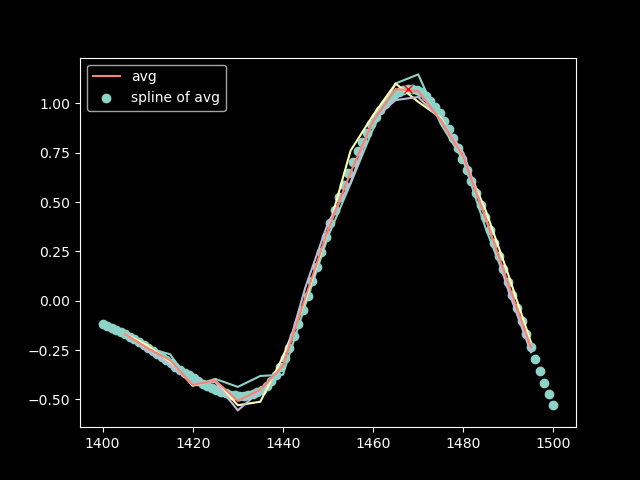

In [197]:
peak_start = 1400
peak_end = 1500
peak = bench_test.get_window(peak_start, peak_end)
peak_spline = bench_test.get_spline_of_window(n_spectrum=-1, n_knots=11, start=peak_start, end=peak_end)
print(peak_spline[1])
plt.figure()
plt.plot(peak[0]['offset1'], peak[0]['H2_pnorm'])
plt.plot(peak[1]['offset1'], peak[1]['H2_pnorm'])
plt.plot(peak[2]['offset1'], peak[2]['H2_pnorm'])
plt.plot(peak[3]['offset1'], peak[3]['H2_pnorm'], label='avg')
plt.scatter(peak_spline[2]['offset1'], peak_spline[2]['H2_pnorm'], label='spline of avg')
plt.plot(peak_spline[-2]['offset1'], peak_spline[-2]['H2_pnorm'], 'rx')
plt.legend()
plt.show()

In [198]:
peak_spline[-2]['H2_pnorm']

67    1.074373
Name: H2_pnorm, dtype: float64

## Work on noise

[[Model]]
    Model(spline_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 24
    # variables        = 10
    chi-square         = 4.5296e-06
    reduced chi-square = 3.2354e-07
    Akaike info crit   = -351.590331
    Bayesian info crit = -339.809793
    R-squared          = 0.97427412
[[Variables]]
    s0: -0.00532503 +/- 0.00161150 (30.26%) (init = -0.001733407)
    s1:  0.00291630 +/- 0.00148990 (51.09%) (init = -0.00010834)
    s2: -0.00272273 +/- 0.00114937 (42.21%) (init = -0.001177084)
    s3: -4.8390e-04 +/- 7.5009e-04 (155.01%) (init = -0.001061618)
    s4: -0.00177435 +/- 7.5595e-04 (42.60%) (init = -0.0006655835)
    s5:  0.00276024 +/- 7.5595e-04 (27.39%) (init = 0.0007116416)
    s6: -0.00417765 +/- 7.5009e-04 (17.95%) (init = -0.001714633)
    s7:  0.00230632 +/- 0.00114937 (49.84%) (init = -0.002348957)
    s8: -0.01695852 +/- 0.00148990 (8.79%) (init = -0.007385042)
    s9: -0.00238356 +/- 0.00161150 (67.6

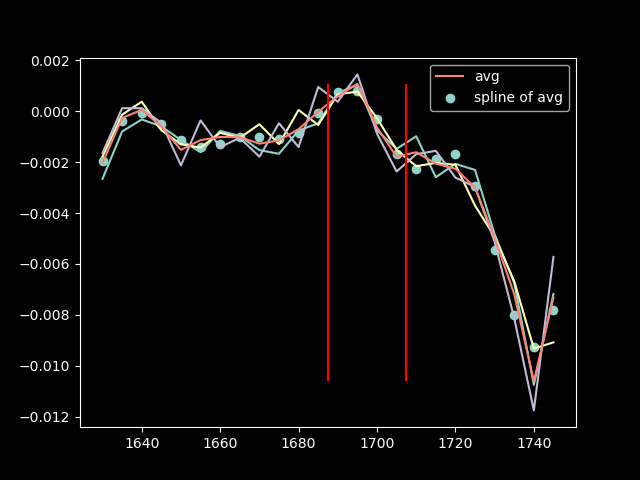

          0         1         2
0  0.000725  0.000669  0.000372
1  0.001026  0.000767  0.001445
2 -0.000752 -0.000273 -0.000882
3 -0.001478 -0.001519 -0.002368
Horizontal stdevs
['1.033359e-03', '9.200215e-04', '1.422887e-03', '1.114771e-03', '1.003027e-03']
0.0011254222995391138
Vertical stdevs
['1.548451e-04', '2.796262e-04', '2.617647e-04', '4.099360e-04']
0.0002765430054833248


In [191]:
%matplotlib widget
flat_regions = bench_test.get_window()
spline_of_avg = bench_test.get_spline_of_window(n_knots=10)
print(spline_of_avg[1])
print(len(flat_regions[3]))
plt.figure()
plt.plot(flat_regions[0]['offset1'], flat_regions[0]['H2_pnorm'])
plt.plot(flat_regions[1]['offset1'], flat_regions[1]['H2_pnorm'])
plt.plot(flat_regions[2]['offset1'], flat_regions[2]['H2_pnorm'])
plt.plot(flat_regions[3]['offset1'], flat_regions[3]['H2_pnorm'], label='avg')
plt.scatter(spline_of_avg[0]['offset1'], spline_of_avg[0]['H2_pnorm'], label='spline of avg')
plt.legend()
plt.vlines([1687.5, 1707.5], ymin=flat_regions[3]['H2_pnorm'].min(), ymax=flat_regions[3]['H2_pnorm'].max(), colors=['red', 'red'])
plt.show()

flat_regions_dict = {
    '0': flat_regions[0],
    '1': flat_regions[1],
    '2': flat_regions[2],
    'avg': flat_regions[3],
    'avg_spline': spline_of_avg[0]
}

stdevs_horizontal = []
stdevs_vertical = []
for k, v in flat_regions_dict.items():
    df = flat_regions_dict[k]
    flat_regions_dict[k] = df[(df['offset1'] > 1687.5) & (df['offset1'] < 1707.5)]
    df = flat_regions_dict[k]
    stdevs_horizontal.append(df['H2_pnorm'].std(ddof=0))

df_std = pd.DataFrame({k: v.reset_index()['H2_pnorm'] for k, v in flat_regions_dict.items()})
df_std = df_std.loc[:,'0':'2']
for i in range(4):
    stdevs_vertical.append(df_std.iloc[i].T.std(ddof=0))
print(df_std)

print('Horizontal stdevs')
print([np.format_float_scientific(i, precision=6) for i in stdevs_horizontal])
print(np.average(np.array(stdevs_horizontal[0:3])))

print('Vertical stdevs')
print([np.format_float_scientific(i, precision=6) for i in stdevs_vertical])
print(np.average(np.array(stdevs_vertical[0:4])))

In [147]:
print((1.548e-4 + 2.796e-4 + 2.618e-4 + 4.099e-4) / 4)
print((1.548e-4 + 2.796e-4 + 2.618e-4) / 4)
print(( + 2.796e-4 + 2.618e-4 + 4.099e-4) / 4)
print(np.std([3.79e-4, 6.69e-4, 7.29e-4]))

0.000276525
0.00017405000000000003
0.000237825
0.00015282524515130202


We can do horizontal and vertical evaluation of stddevs in the region, say, 

2.74e-04


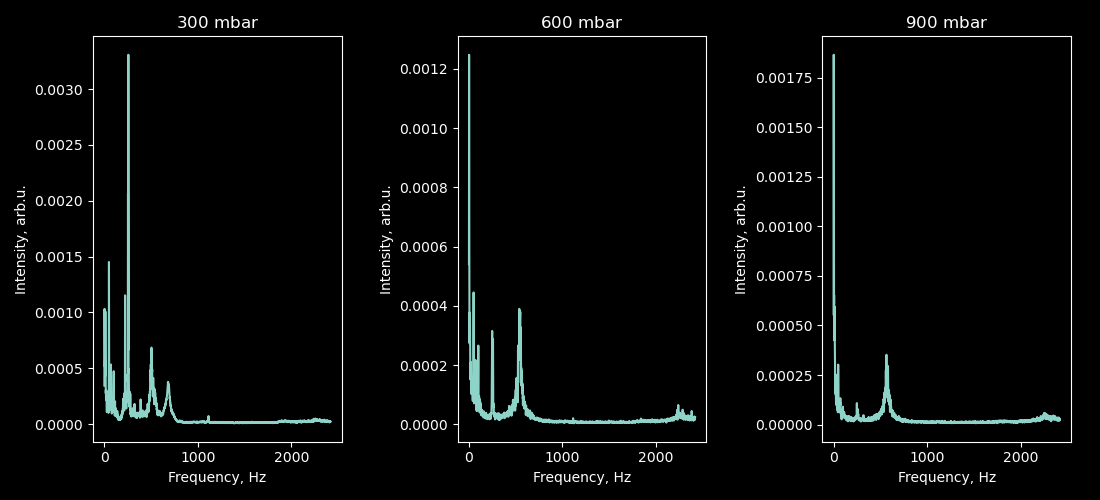

In [164]:


bench_noise_300 = CEPAS_noise_info(benchmark_noise, 300)
bench_noise_600 = CEPAS_noise_info(benchmark_noise, 600)
bench_noise_900 = CEPAS_noise_info(benchmark_noise, 900)
print(f"{np.format_float_scientific(bench_noise_300.get_noise_at(f), precision=3)}")
plt.close()
plt.figure(figsize=(11, 5))
plt.subplot(131)
plt.title("$300\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_300.spectrum['freq'], bench_noise_300.spectrum['intensity'])
plt.subplot(132)
plt.title("$600\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_600.spectrum['freq'], bench_noise_600.spectrum['intensity'])
plt.subplot(133)
plt.title("$900\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_900.spectrum['freq'], bench_noise_900.spectrum['intensity'])
plt.tight_layout()
plt.show()

## Compilation of all benchmark measurements

Stack 3 barplots (for each pressure), 3 bars for each method of SNR, for all frequencies

In [192]:
noise_start = 1625
noise_end = 1750
bench_final = CEPAS_SNR_bench(test_bench_files, bench_path=benchmark_path, noise_path=benchmark_noise)
get_all = bench_final.get_all_snrs([peak_start, noise_start], [peak_end, noise_end]) # float=1625, end: int | float=1750
df_snr = get_all[0]
df_noise = get_all[1]

In [186]:
type(df_snr[300][20][0])
df_snr[300][20][0]

945.7415854970517

In [187]:
df_snr.columns[0]

np.int64(300)

/tmp/ipykernel_1997/1040794540.py:77: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(pad=5)
/tmp/ipykernel_1997/1040794540.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


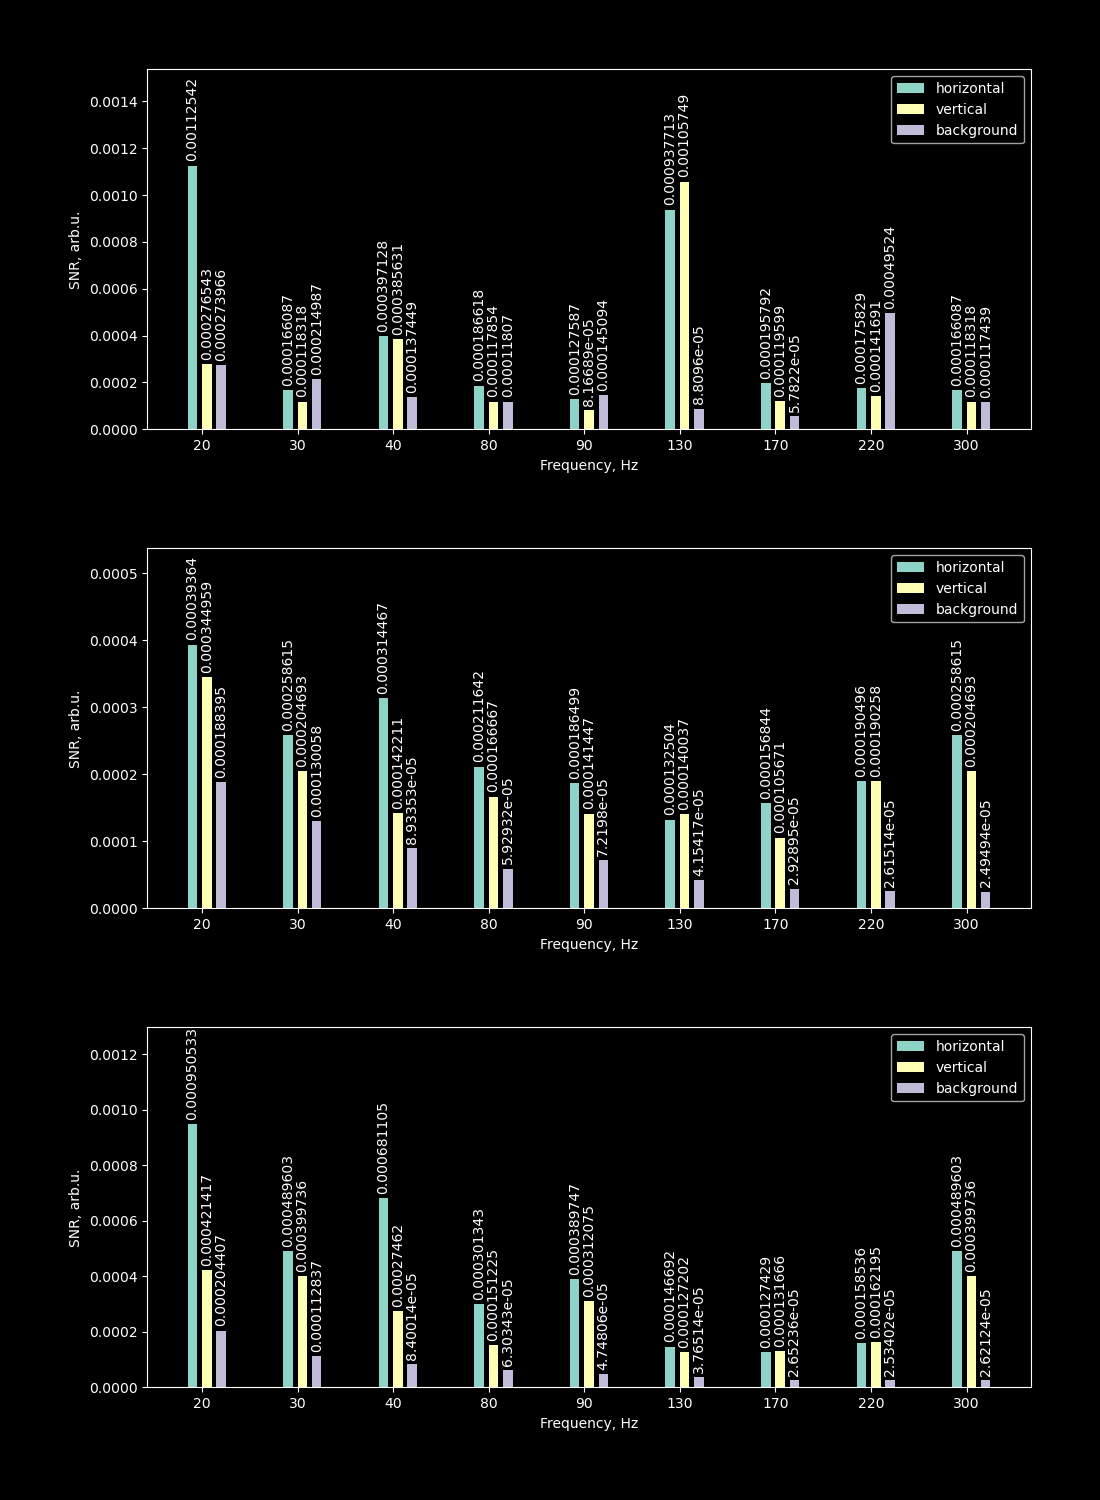

In [201]:
norm_factor300 = np.divide(1, np.array([df_snr[300][f][2] for f in df_snr.index]).max())
norm_factor600 = np.divide(1, np.array([df_snr[300][f][2] for f in df_snr.index]).max())
norm_factor900 = np.divide(1, np.array([df_snr[300][f][2] for f in df_snr.index]).max())

noises300 = {
    'horizontal': [df_noise[300][f][0] for f in df_snr.index],
    'vertical': [df_noise[300][f][1] for f in df_snr.index],
    'background': [df_noise[300][f][2] for f in df_snr.index]
}

noises600 = {
    'horizontal': [df_noise[600][f][0] for f in df_snr.index],
    'vertical': [df_noise[600][f][1] for f in df_snr.index],
    'background': [df_noise[600][f][2] for f in df_snr.index]
}

noises900 = {
    'horizontal': [df_noise[900][f][0] for f in df_snr.index],
    'vertical': [df_noise[900][f][1] for f in df_snr.index],
    'background': [df_noise[900][f][2] for f in df_snr.index]
}

frequencies = df_snr.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3


plt.figure(figsize=(11, 15), constrained_layout=True)

ax1 = plt.subplot(311)
for k, v in noises300.items():
    offset = (width+spacing) * multiplier
    rects = ax1.bar(x+offset, v, width, label=k)
    ax1.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax1.set_xticks(x+width, np.round(list(frequencies), 2))
ax1.set_xlabel('Frequency, Hz')
ax1.set_ylabel('SNR, arb.u.')
old_top = ax1.get_ylim()[1]
new_top = old_top*top_align
ax1.set_ylim(top=new_top)
ax1.legend()
multiplier = 0

ax2 = plt.subplot(312)
for k, v in noises600.items():
    offset = (width+spacing) * multiplier
    rects = ax2.bar(x+offset, v, width, label=k)
    ax2.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax2.set_xticks(x+width, np.round(list(frequencies), 2))
ax2.set_xlabel('Frequency, Hz')
ax2.set_ylabel('SNR, arb.u.')
old_top = ax2.get_ylim()[1]
new_top = old_top*top_align
ax2.set_ylim(top=new_top)
ax2.legend()
multiplier = 0

ax3 = plt.subplot(313)
for k, v in noises900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('SNR, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

/tmp/ipykernel_1997/3293126991.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


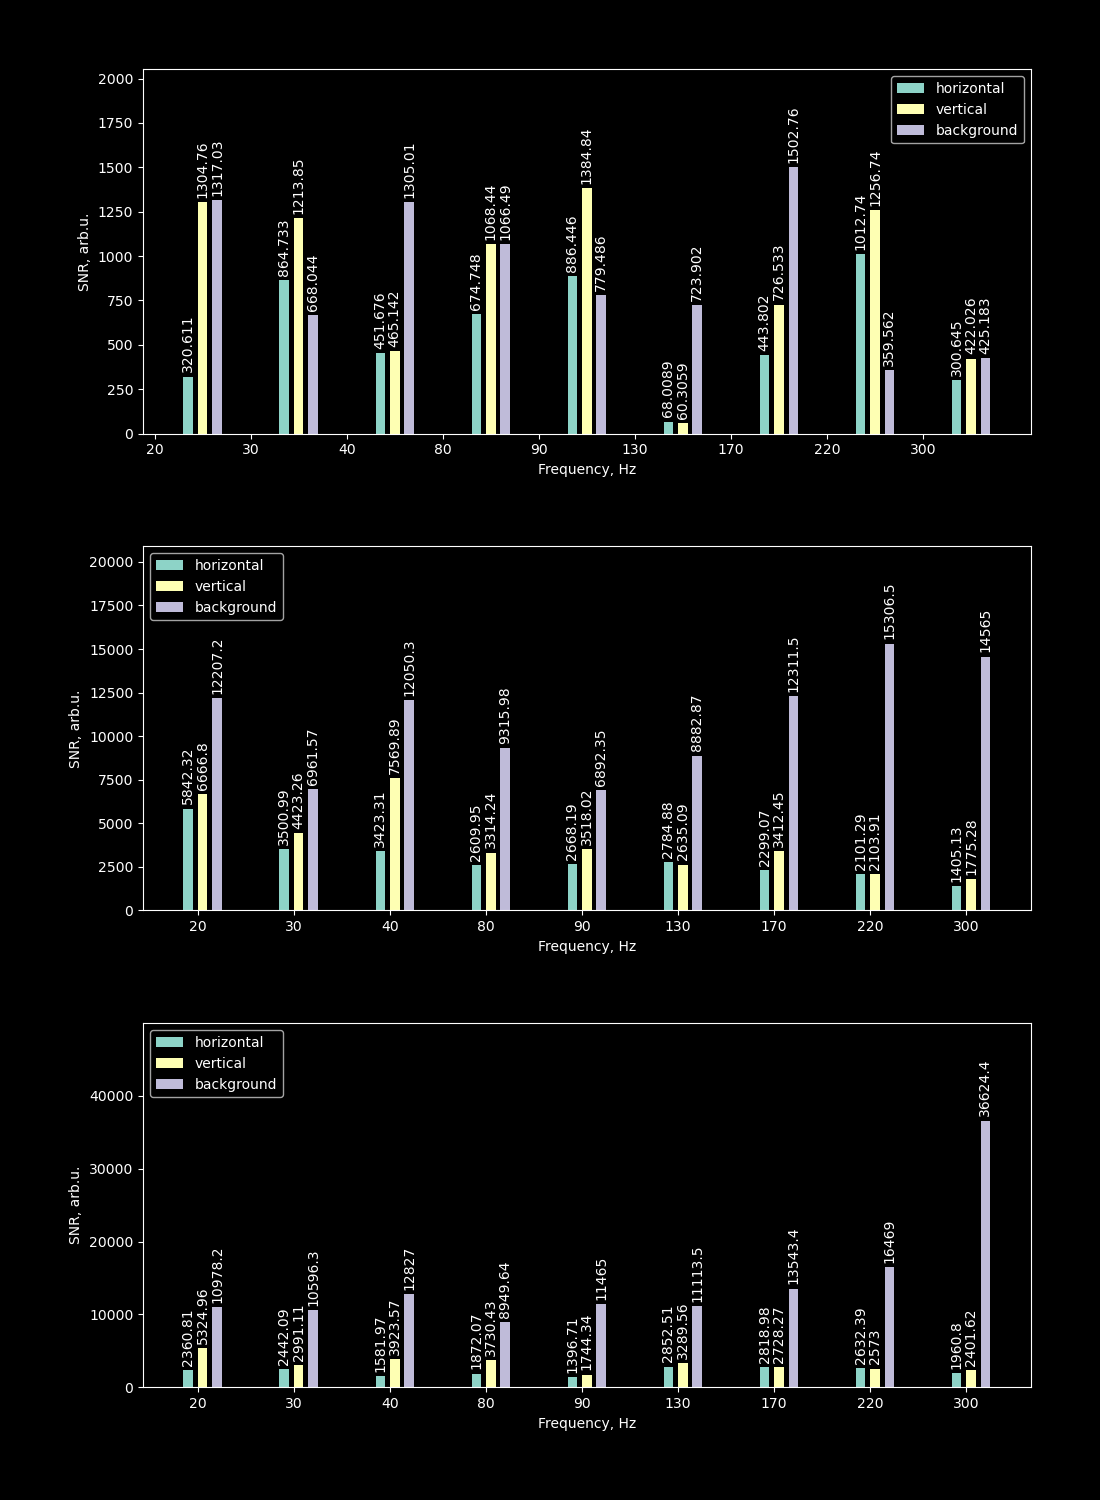

In [202]:
noises300 = {
    'horizontal': [df_snr[300][f][0] for f in df_snr.index],
    'vertical': [df_snr[300][f][1] for f in df_snr.index],
    'background': [df_snr[300][f][2] for f in df_snr.index]
}

noises600 = {
    'horizontal': [df_snr[600][f][0] for f in df_snr.index],
    'vertical': [df_snr[600][f][1] for f in df_snr.index],
    'background': [df_snr[600][f][2] for f in df_snr.index]
}

noises900 = {
    'horizontal': [df_snr[900][f][0] for f in df_snr.index],
    'vertical': [df_snr[900][f][1] for f in df_snr.index],
    'background': [df_snr[900][f][2] for f in df_snr.index]
}




plt.figure(figsize=(11, 15), constrained_layout=True)

ax1 = plt.subplot(311)
for k, v in noises300.items():
    offset = (width+spacing) * multiplier
    rects = ax1.bar(x+offset, v, width, label=k)
    ax1.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax1.set_xticks(x+width, np.round(list(frequencies), 2))
ax1.set_xlabel('Frequency, Hz')
ax1.set_ylabel('SNR, arb.u.')
old_top = ax1.get_ylim()[1]
new_top = old_top*top_align
ax1.set_ylim(top=new_top)
ax1.legend()
multiplier = 0

ax2 = plt.subplot(312)
for k, v in noises600.items():
    offset = (width+spacing) * multiplier
    rects = ax2.bar(x+offset, v, width, label=k)
    ax2.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax2.set_xticks(x+width, np.round(list(frequencies), 2))
ax2.set_xlabel('Frequency, Hz')
ax2.set_ylabel('SNR, arb.u.')
old_top = ax2.get_ylim()[1]
new_top = old_top*top_align
ax2.set_ylim(top=new_top)
ax2.legend()
multiplier = 0

ax3 = plt.subplot(313)
for k, v in noises900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('SNR, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

# Whiteboard

In [56]:
%matplotlib inline
def offs2uvolts(stock):
    return (stock-768)/10*1000+37000

print(f"min: {offs2uvolts(1300)/1000} mV\nmax: {offs2uvolts(2130)/1000} mV\n")

min: 90.2 mV
max: 173.2 mV



In [57]:
R = 100e6
S = 3968
tau = 10
1/(R/2**tau)*S

0.04063232

In [58]:
offsets_dec = [768.0, 2130.0]
scope = [37.0, 182.0]
_, a, b = get_wavenumber(1, scope, offsets_dec)
val1 = 189.0 + 1.25
val2 = 189.0 - 1.25
val1_offset = a*val1 + b
val2_offset = a*val2 + b
f1 = get_wavenumber(val1_offset, units1, units2)
f2 = get_wavenumber(val2_offset, units1, units2)
print(f2[0]-f1[0])

0.08271534728373808


In [59]:
diff88_8 = subtract_hex("00088", "00008")
int(diff88_8, 16)/8

16.0

In [60]:
def f(x):
    return x

interact(f, x=10)



interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>

In [61]:
np.round(np.geomspace(32, 300, 9, endpoint=True))

array([ 32.,  42.,  56.,  74.,  98., 130., 171., 227., 300.])

# Misc

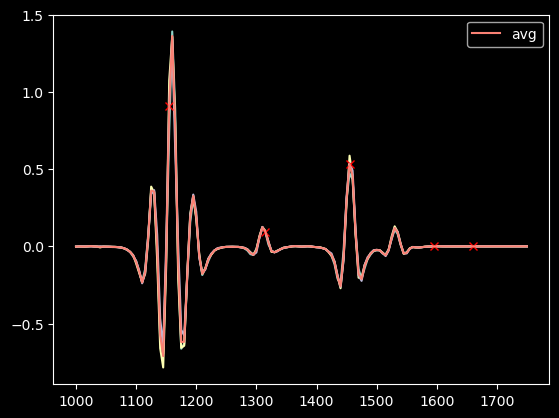

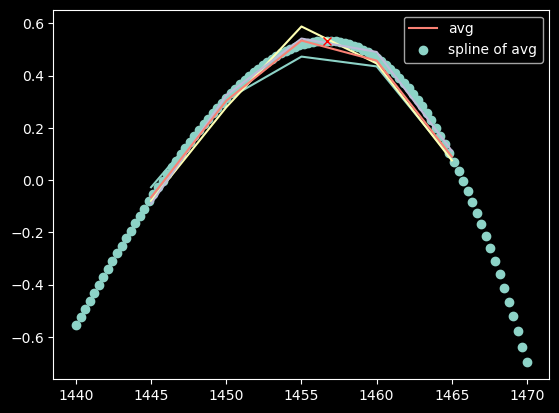

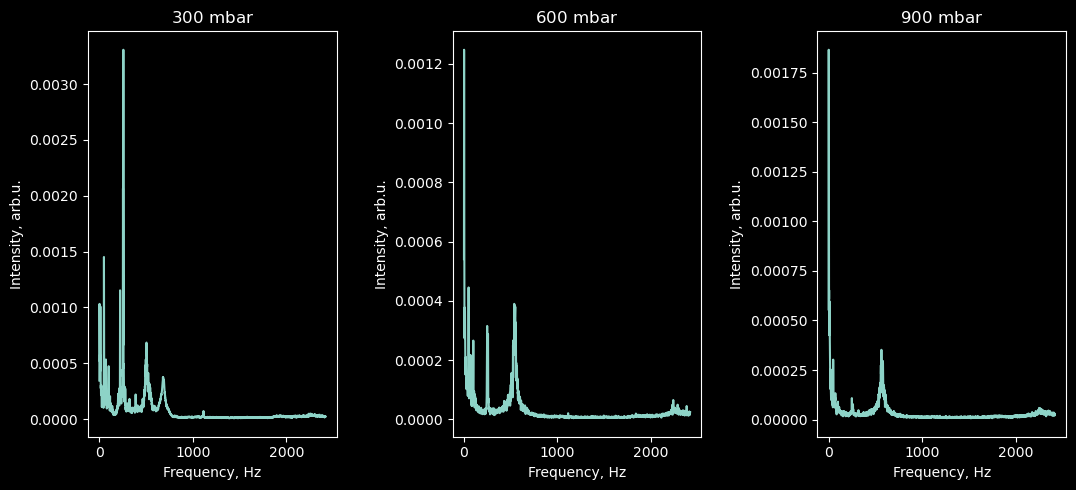

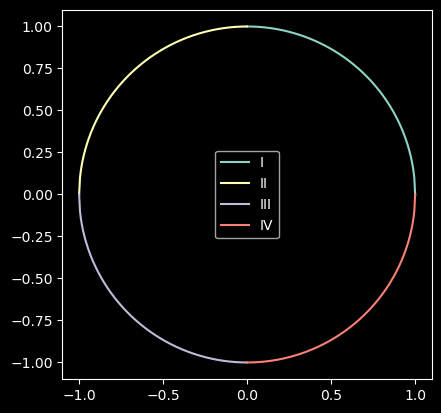

In [62]:
plt.close()
r = 1
A = np.pi * r**2
x_arr = np.linspace(0.001, 1, 200)
def circle(x, r=1.0):
    expression = r - np.pow(x, 2)
    return np.sqrt(expression)

# print(x_arr)
plt.figure()
plt.gca().set_aspect('equal')
plt.plot(x_arr, circle(x_arr, r), label="I")
plt.plot(-x_arr, circle(x_arr, r), label="II")
plt.plot(-x_arr, -circle(x_arr, r), label="III")
plt.plot(x_arr, -circle(x_arr, r), label="IV")
plt.legend()
plt.show()

In [63]:
area_test, err = quad(circle, 0, 1, args=(1,))
print(round(4*area_test, 14))
print(round(np.pi, 14))


3.14159265358979
3.14159265358979


In [64]:
def custom_integral(f, x1, x0=0, step_denominator=1e6):
    dx = 1/step_denominator
    x_values = np.linspace(x0+dx, x1, int(step_denominator))
    return np.sum(f(x_values, x1)*dx)

4*custom_integral(f=circle, x1=1.0)

np.float64(3.1415906524138117)

# Tutorials

## `scipy.signal.find_peaks`

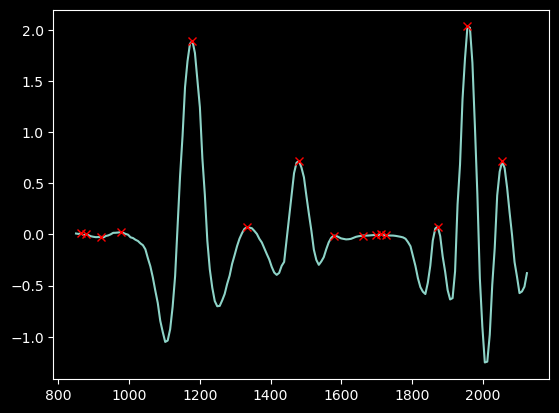

time  offset1     P1     H3     H2  P_las  T_las     RH  Pressure  \
1    False    False  False  False  False  False  False  False     False   
2    False    False  False  False  False  False  False  False     False   
3    False    False  False  False  False  False  False  False     False   
4    False    False  False  False  False  False  False  False     False   
5    False    False  False  False  False  False  False  False     False   
..     ...      ...    ...    ...    ...    ...    ...    ...       ...   
179  False    False  False  False  False  False  False  False     False   
180  False    False  False  False  False  False  False  False     False   
181  False    False  False  False  False  False  False  False     False   
182  False    False  False  False  False  False  False  False     False   
183  False    False  False  False  False  False  False  False     False   

     time_subtracted  H2_pnorm  H3_pnorm  
1              False     False     False  
2              False     False     False  
3              False     False     False  
4              False     False     False  
5              False     False     False  
..               ...       ...       ...  
179            False     False     False  
180            False     False     False  
181            False     False     False  
182            False     False     False  
183            False     False     False  

[183 rows x 12 columns]

In [65]:
df = cm_22deg_600.spectra_list[0]
test_peaks, _ = find_peaks(df['H2_pnorm'])

plt.close()
plt.figure()
plt.plot(df['offset1'], df['H2_pnorm'])
plt.plot(df['offset1'].iloc[test_peaks], df['H2_pnorm'].iloc[test_peaks], 'rx')
plt.show()
# test_peaks[0]
# df.loc[1,:]
# df_peaks
df.isna()

## `lmfit`

[[Model]]
    ((Model(voigt, prefix='v1_') + Model(voigt, prefix='v2_')) + Model(constant, prefix='const_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 1001
    # variables        = 8
    chi-square         = 40.9940206
    reduced chi-square = 0.04128300
    Akaike info crit   = -3182.52389
    Bayesian info crit = -3143.25385
    R-squared          = 0.98008490
[[Variables]]
    v1_amplitude:  14.5726251 +/- 0.16323844 (1.12%) (init = 28.13403)
    v1_center:     8999.99657 +/- 0.00522201 (0.00%) (init = 9000)
    v1_sigma:      0.55783081 +/- 0.01371529 (2.46%) (init = 0.4875)
    v1_gamma:      0.21728002 +/- 0.01957746 (9.01%) (init = 0.4875)
    v1_fwhm:       1.56137397 +/- 0.01468660 (0.94%) == '1.0692*v1_gamma+sqrt(0.8664*v1_gamma**2+5.545083*v1_sigma**2)'
    v1_height:     7.83539061 +/- 0.05592241 (0.71%) == '(v1_amplitude/(max(1e-15, v1_sigma*sqrt(2*pi))))*real(wofz((1j*v1_gamma)/(max(1e-15, v1_sigma*sqrt(2)))))

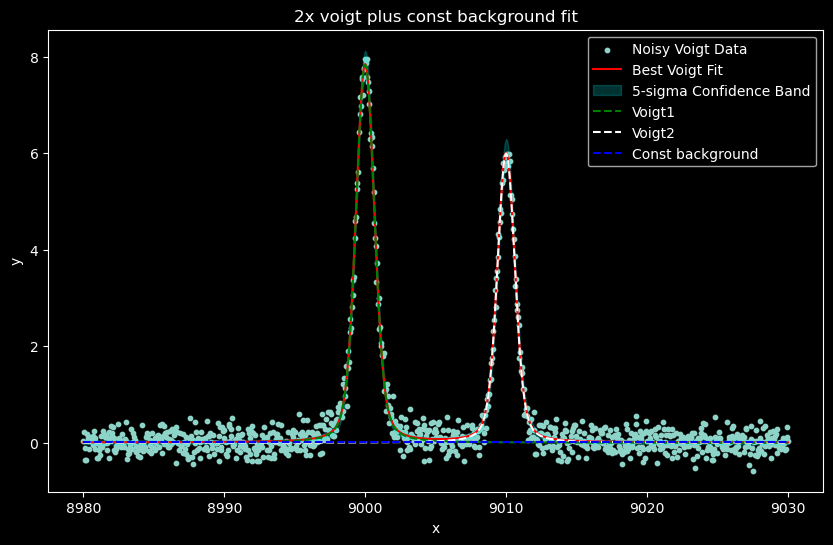

In [66]:
x = np.linspace(8980, 9030, 1001) # creating x axis linspave

# defining true params for arbitrary simulation
voigt1_true = {'amplitude': 15.0, 'center': 9000, 'sigma': 0.5, 'gamma': 0.3}
voigt2_true = {'amplitude': 10.0, 'center': 9010, 'sigma': 0.6, 'gamma': 0.1}
const_true = {'offs': 1.5}

# creating 'true' data for arbitrary somulation on x axis
y = np.asarray(VoigtModel().eval(x=x, **voigt1_true)) +\
    np.asarray(VoigtModel().eval(x=x, **voigt2_true)) +\
    np.asarray(ConstantModel().eval(x=x, **const_true))

# creating noise and adding it to 'true' data
noise = np.random.normal(0, 0.2, size=x.size)
y_noisy = y + noise

# creating model to fit, using custom prefixes for easier param ID later
m1 = VoigtModel(prefix='v1_')
m2 = VoigtModel(prefix='v2_')
m3 = ConstantModel(prefix='const_')
model = m1 + m2 + m3

# defining initial guesses (close to 'true' params)
p1 = m1.guess(y_noisy[300:500], x=x[300:500])
p2 = m2.guess(y_noisy[500:], x=x[500:])
p3 = m3.guess(y_noisy[0:300], x=x[0:300])
params = p1 + p2 + p3

# setting off from the default sigma=gamma by enabling gamma variation
params['v1_gamma'].set(vary=True)
params['v2_gamma'].set(expr='v1_gamma')

# calling the fit
result = model.fit(y_noisy, params, x=x)

# confidence bands
confidence_sigma = 5
dely = result.eval_uncertainty(sigma=confidence_sigma)

# extracting individual components from the composite model
comps = result.eval_components()

# creating fit report
print(result.fit_report())
# print(result.conf_interval())
plt.close()
plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, label='Noisy Voigt Data', s=10)
plt.plot(x, result.best_fit, 'r-', label='Best Voigt Fit')
plt.fill_between(
    x, result.best_fit - dely, result.best_fit + dely,
    color='cyan', alpha=0.2,
    label=f'{confidence_sigma}-sigma Confidence Band')
plt.plot(x, comps['v1_'], 'g--', label='Voigt1')
plt.plot(x, comps['v2_'], 'w--', label='Voigt2')
plt.plot(x, comps['const_'], 'b--', label='Const background')

plt.xlabel('x')
plt.ylabel('y')
plt.title('2x voigt plus const background fit')
plt.legend()
# plt.xlim(8995, 9005)
plt.show()

[[Model]]
    Model(spline_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 101
    # variables        = 15
    chi-square         = 0.96064621
    reduced chi-square = 0.01117030
    Akaike info crit   = -440.182230
    Bayesian info crit = -400.955423
    R-squared          = 0.97895354
[[Variables]]
    s0:   0.04718293 +/- 0.07648814 (162.11%) (init = -0.01766386)
    s1:   0.63087246 +/- 0.11880622 (18.83%) (init = 0.7472346)
    s2:   1.10267962 +/- 0.11568025 (10.49%) (init = 0.9765863)
    s3:   0.91485461 +/- 0.08304592 (9.08%) (init = 0.882895)
    s4:   0.35617710 +/- 0.08667290 (24.33%) (init = 0.3303776)
    s5:  -0.42177392 +/- 0.08775833 (20.81%) (init = -0.5242564)
    s6:  -1.05917716 +/- 0.08806425 (8.31%) (init = -0.9600522)
    s7:  -0.93194264 +/- 0.08812808 (9.46%) (init = -0.7782251)
    s8:  -0.68999093 +/- 0.08806425 (12.76%) (init = -0.5668217)
    s9:   0.24605083 +/- 0.08775833 (35.67%) (init = 0

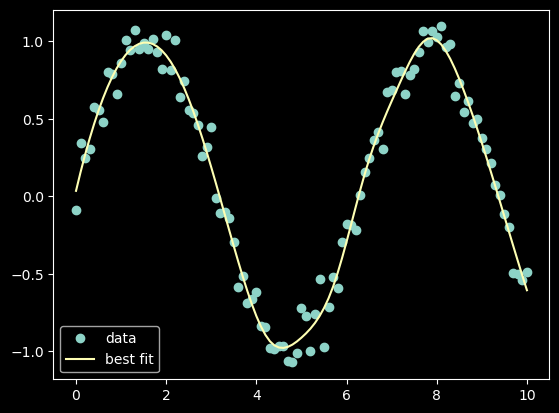

In [67]:
# Generate some sample data
x = np.linspace(0, 10, 101)
y = np.sin(x) + np.random.normal(scale=0.1, size=x.size)

# Create a SplineModel with 7 knots
smodel = SplineModel(xknots=np.linspace(0.01, 9.99, 15))

# Generate initial parameters
params = smodel.guess(y, x=x)

# Fit the model to the data
result = smodel.fit(y, params, x=x)

# Print the fit report
print(result.fit_report())

# Plot the results
plt.close()
plt.figure()
plt.plot(x, y, 'o', label='data')
plt.plot(x, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()